<a href="https://colab.research.google.com/github/Crippius/active_learning_project/blob/main/active_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs, Imports and Initializations

In [1]:
%%capture
!pip install sentence_transformers

In [2]:
%%capture

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from IPython.display import display
from sklearn.manifold import TSNE
from keras import backend as K
from google.colab import drive
from math import pow, sqrt
import random
import time


drive.mount('/content/drive')

In [3]:
# @title Choose which dataset to use
LABEL = "casualty" #@param ["casualty", "damage", "weapons"]

SAMPLE = 225000 # @param {type:"slider", min:0, max:300000, step:1000}

df = pd.read_pickle(f"/content/drive/MyDrive/Uni/Terzo anno/Progetto di Ingegneria Informatica/code/{LABEL}.pickle")
if SAMPLE < len(df):
  df = df.sample(SAMPLE)

In [4]:
%%capture
# @title Choose which embedding method to use
EMBEDDING_TYPE = "fast" # @param ["fast", "precise"]

types_of_embedding = {"fast":{"name":"all-MiniLM-L6-v2", "dim":384},
                   "precise":{"name":"all-mpnet-base-v2", "dim":768}}

EMBEDDING_MODEL = SentenceTransformer(types_of_embedding[EMBEDDING_TYPE]["name"])
EMBEDDING_DIMENSION = types_of_embedding[EMBEDDING_TYPE]["dim"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
# @title Active Learning configurations
BUDGET = 1000 # @param {type:"slider", min:0, max:10000, step:100}

AL_METHOD = "minimax" # @param ["random", "farthest_first", "minimax"]

AL_EFFICIENCY = "normal" # @param ["optimal", "normal", "forgetful"]

In [ ]:
# @title Neural network configurations
EPOCHS = 12 # @param {type:"slider", min:0, max:100, step:1}
BATCH_SIZE = 32 # @param {type:"slider", min:0, max:100, step:1}
TRAIN_RATIO = 0.80 # @param {type:"slider", min:0, max:1, step:0.05}
LEARNING_RATE = 1e-3 # @param {type:"slider", min:0.0001, max:0.1, step:0.00001}
VALIDATION_RATIO = 1-TRAIN_RATIO

In [7]:
# @title Additional possible analysis
EXECUTE_EMBEDDING = False # @param {type:"boolean"}
CHECK_POSITION = False # @param {type:"boolean"}
BEST_SCENARIO = True # @param {type:"boolean"}

In [5]:
# @title Thresholds + Seed
DECISION_THRESHOLD = 0.5 # @param {type:"slider", min:0, max:1, step:0.1}
CLASSIFICATION_THRESHOLD = 0.1 # @param {type:"slider", min:0, max:1, step:0.1}

def decision(cnn_output):
  return cnn_output > DECISION_THRESHOLD

def classify(label):
  return label > CLASSIFICATION_THRESHOLD

# Seed initialization
SEED = 42 # @param {type:"integer"}

np.random.seed(SEED)
tf.random.set_seed(SEED)

## Dataset study


Example of Tweet

In [9]:
print("Example of tweet")
x = df.sample()
x

Example of tweet


,tid,cid,text,retweet_count,reply_count,like_count,quote_count,impression_count,text_clean,ts,tid_str,casualty,embedding
225246,1498243364323479558,1.498243e+18,How much Russia is ready for Western Sanctions...,0.0,0.0,0.0,0,0.0,How much Russia is ready for Western Sanctions...,2022-02-28 09:27:08.727,1498243364323479558,0.0,"(0.0066395592875778675, -0.04070671275258064, ..."


In [10]:
print(x.iloc[0].text_clean)

How much Russia is ready for Western Sanctions? sanctionsrussia worldnews internationalnews russiaukraineupdates usrussiaukrainenews


In [11]:
print(f"Example of tweet (possibly) talking about {LABEL}")
x = df[df[LABEL] == 1.0].sample()
x

Example of tweet (possibly) talking about casualty


,tid,cid,text,retweet_count,reply_count,like_count,quote_count,impression_count,text_clean,ts,tid_str,casualty,embedding
137282,1500669711960645634,1.500670e+18,“War is a racket” — mass murder for the profit...,0.0,0.0,0.0,0,0.0,“War is a racket” — mass murder for the profit...,2022-03-07 02:08:35.083,1500669711960645634,1.0,"(0.01593117043375969, 0.09688816219568253, -0...."


In [12]:
print(x.iloc[0].text_clean)

“War is a racket” — mass murder for the profits of blood-drenched arms dealers


In [13]:
df.dtypes

tid                         object
cid                        float64
text                        object
retweet_count              float64
reply_count                float64
like_count                 float64
quote_count                 object
impression_count           float64
text_clean                  object
ts                  datetime64[ns]
tid_str                     object
casualty                   float64
embedding                   object
dtype: object

In [14]:
df.describe()

,cid,retweet_count,reply_count,like_count,impression_count,casualty
count,2.220000e+05,222000.000000,222000.000000,222000.000000,222000.0,222000.000000
mean,1.498535e+18,8.836185,2.039793,41.540122,0.0,0.178402
std,1.470144e+15,387.099010,40.754452,1717.592435,0.0,0.333865
min,1.495978e+18,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.497190e+18,0.000000,0.000000,0.000000,0.0,0.000000
50%,1.498665e+18,0.000000,0.000000,0.000000,0.0,0.000000
75%,1.499781e+18,0.000000,0.000000,2.000000,0.0,0.200000
max,1.500985e+18,137192.000000,10902.000000,592504.000000,0.0,1.000000


Percent of tweets possibly talking about casualty: 28.6%


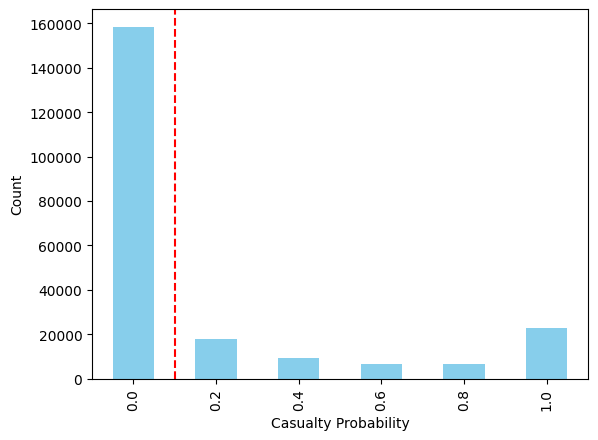

In [44]:
print(f"Percent of tweets possibly talking about {LABEL}: {round(100 * len(df[df[LABEL] > CLASSIFICATION_THRESHOLD]) / len(df), 2)}%")


counts = df['casualty'].round(2).value_counts().sort_index()
counts.plot(kind='bar', color='skyblue')
plt.axvline(x=CLASSIFICATION_THRESHOLD*5, color='red', linestyle='--')
plt.xlabel('Casualty Probability')
plt.ylabel('Count')
plt.show()

In [16]:
min_date = df.ts.min().date()
max_date = df.ts.max().date()
print(f"Batch of tweets about Ukraine's conflict uploaded from {min_date} to {max_date}")

Batch of tweets about Ukraine's conflict uploaded from 2022-02-22 to 2022-03-07


Average number of tweets per day: 15857.0 tweets


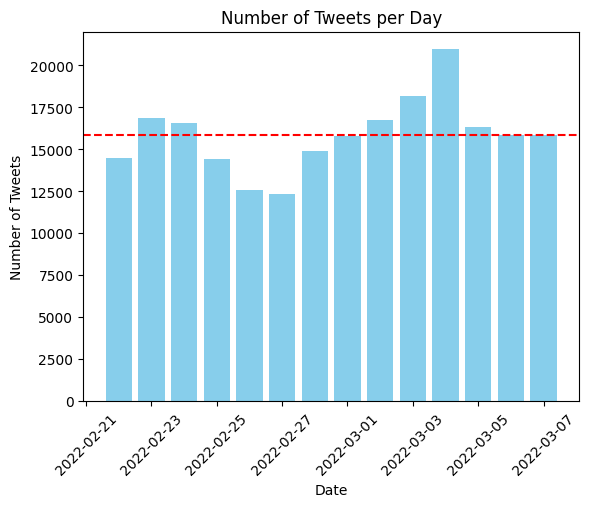

In [42]:
tweets_per_day = df["ts"].dt.date.value_counts().sort_index()
# Plotting the histogram
mean = round(sum(tweets_per_day.values) / len(tweets_per_day.values), 0)
print(f"Average number of tweets per day: {mean} tweets")

plt.bar(tweets_per_day.index, tweets_per_day.values, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Day')
plt.axhline(y=mean, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.show()

## Embedding tweets

In [18]:
# Returns the same df but with an additional column "embedding" of the (clean) tweet
def embed_df(df):

    embedded_tweets = EMBEDDING_MODEL.encode(df["text_clean"])

    df["embedding"] = embedded_tweets

    return df


# Returns embedded text
def embed_text(txt):

    return EMBEDDING_MODEL.encode(txt)

In [19]:
if EXECUTE_EMBEDDING:
  df = embed_df(df)

## Building the model

In [20]:
# Metrics to check during model training

# Recall: ability to identify all relevant instances (TP / TP + FN)
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Precision: ability to distinguish relevant instances from others (TP / TP + FP)
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1: mean of precision and recall (2*precision*recall / precision+recall)
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
def create_model():

  model = tf.keras.Sequential([
      tf.keras.Input(shape=(EMBEDDING_DIMENSION,), dtype="float32"),
      tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
  ])
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics = [tf.keras.metrics.BinaryAccuracy(threshold=DECISION_THRESHOLD), recall_m, precision_m, f1_m])

  # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10).
  # Get only the best model out of every epoch
  callback = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy', save_best_only=True, mode='max', verbose=0, patience=10, filepath='prova.h5')

  return model, callback


model, _ = create_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                24640     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 batch_normalization_1 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

## Active Learning Methods

In [22]:
# Core Set: Farthest First Traversal (Approximated version)
def cs_farthest_first_selection(df, labelled, budget, label_column):
  df = df.reset_index(drop=True)

  points = df["embedding"].tolist()

  distances = euclidean_distances(points, points)

  while budget > 0:

    chosen = random.randint(0, len(df) - 1)

    curr = time.time()

    furthest = 0
    furthest_dist = 0

    # Searching for the element furthest away from the currently chosen one
    for i in range(len(df)):


      total_distance = distances[chosen, i]

      if furthest_dist < total_distance:
        # Avoiding elements already labelled
        if df.iloc[i]["embedding"] in list(labelled.keys()):
          continue
        furthest = i
        furthest_dist = total_distance


    labelled[df.iloc[furthest]["embedding"]] = classify(df.iloc[furthest][LABEL])

    budget -= 1

  del distances
  return labelled


In [23]:
# Core Set: Minimax (Correct version)
def cs_minimax_selection(df, labelled, budget, label_column):
  df = df.reset_index(drop=True)

  start = time.time()
  start_budget = budget

  points = df["embedding"].tolist()

  if len(labelled) == 0:
      labelled = {df.iloc[0]["embedding"]:df.iloc[0][LABEL]}

  distances = euclidean_distances(np.array(list(labelled.keys())), points)

  min_values = distances.min(axis=0)

  distances = euclidean_distances(points, points)


  while budget > 0:
    # Get argmax of minimum distances
    argmax = min_values.argmax()

    labelled[df.iloc[argmax]["embedding"]] = classify(df.iloc[argmax][LABEL])

    min_values = np.array([min(min_values[i], distances[argmax][i]) for i in range(len(min_values))])

    budget -= 1

  return labelled

In [24]:
# Good old random selection
def random_selection(curr, labelled:dict, budget:int, label_column:str):

  curr = curr.sample(budget)
  for i, label in zip(curr['embedding'], curr[label_column]):
    labelled[i] = classify(label)

  return labelled


In [25]:
al_methods = {"minimax":cs_minimax_selection,
              "farthest_first":cs_farthest_first_selection,
              "random":random_selection}

In [26]:
# Testing if Core Set Farthest First selection works
def check_label_position(df, labels, show_label=False):

  test = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=4).fit_transform(np.array(list(df["embedding"])))
  test = pd.DataFrame(test, columns = ["0_", "1_"])

  test["selected"] = [1 if i in labels.keys() else 0 for i in df["embedding"]]
  test[LABEL] = [i for i in df[LABEL]]
  test_labelled = test[test["selected"] == 1]

  plt.scatter(test["0_"], test["1_"], marker="x", c="black")
  if show_label:
    false_labels = test_labelled[test_labelled[LABEL] == 0]
    plt.scatter(false_labels["0_"], false_labels["1_"], marker="x", c="red")
    true_labels = test_labelled[test_labelled[LABEL] == 1]
    plt.scatter(true_labels["0_"], true_labels["1_"], marker="x", c="green")

  else:
    plt.scatter(test_labelled["0_"], test_labelled["1_"], marker="x", c="cyan")

  plt.show()


In [27]:
if CHECK_POSITION:
  curr = df[df.ts.dt.date == min_date]

  for method in al_methods.keys():
    labelled_elements = al_methods[method](curr, {}, BUDGET, LABEL)
    print(f"{method} selection")
    check_label_position(curr, labelled_elements, show_label=True)


In [28]:
def get_network_sets(x, y, next):

  # Splitting data into training, validation and test set
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=TRAIN_RATIO, random_state=SEED)
  x_test, y_test = next['embedding'], next[LABEL]

  # Changing format to correctly use in neural network
  x_train = np.array([np.array(val) for val in x_train])
  y_train = np.array([np.array(val) for val in y_train])
  x_test = np.array([np.array(val) for val in x_test])
  y_test = np.array([np.array(val) for val in y_test])
  x_val = np.array([np.array(val) for val in x_val])
  y_val = np.array([np.array(val) for val in y_val])

  x_train = tf.cast(x_train , dtype=tf.float32)
  y_train = tf.cast(y_train , dtype=tf.float32)
  x_test = tf.cast(x_train , dtype=tf.float32)
  y_test = tf.cast(y_train , dtype=tf.float32)
  x_val = tf.cast(x_train , dtype=tf.float32)
  y_val = tf.cast(y_train , dtype=tf.float32)

  return x_train, y_train, x_test, y_test, x_val, y_val

In [29]:
def plot_results(history, train=True, validation=True, precision=False, recall=False, f1=False):

  legend = []
  if train:
    plt.plot(history.history['binary_accuracy'])
    legend.append("train")
  if validation:
    plt.plot(history.history['val_binary_accuracy'])
    legend.append("validation")
  if precision:
    plt.plot(history.history['precision_m'])
    legend.append("validation")
  if recall:
    plt.plot(history.history['recall_m'])
    legend.append("recall")
  if f1:
    plt.plot(history.history['f1_m'])
    legend.append("f1")

  plt.title(f'model accuracy')
  plt.ylabel('performance metrics')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.show()

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1388/1388 [==============================] - ETA: 0s - loss: 0.5018 - binary_accuracy: 0.7395 - recall_m: 0.4265 - precision_m: 0.7186 - f1_m: 0.4785

1388/1388 [==============================] - 14s 8ms/step - loss: 0.5018 - binary_accuracy: 0.7395 - recall_m: 0.4265 - precision_m: 0.7186 - f1_m: 0.4785 - val_loss: 0.3321 - val_binary_accuracy: 0.7566 - val_recall_m: 0.2999 - val_precision_m: 0.7864 - val_f1_m: 0.4148
Epoch 2/12
1383/1388 [============================>.] - ETA: 0s - loss: 0.3429 - binary_accuracy: 0.7516 - recall_m: 0.2948 - precision_m: 0.8121 - f1_m: 0.4113

1388/1388 [==============================] - 21s 15ms/step - loss: 0.3429 - binary_accuracy: 0.7516 - recall_m: 0.2950 - precision_m: 0.8128 - f1_m: 0.4117 - val_loss: 0.3295 - val_binary_accuracy: 0.7564 - val_recall_m: 0.2958 - val_precision_m: 0.7827 - val_f1_m: 0.4104
Epoch 3/12
1388/1388 [==============================] - ETA: 0s - loss: 0.3314 - binary_accuracy: 0.7515 - recall_m: 0.2876 - precision_m: 0.8244 - f1_m: 0.4061

1388/1388 [==============================] - 15s 11ms/step - loss: 0.3314 - binary_accuracy: 0.7515 - recall_m: 0.2876 - precision_m: 0.8244 - f1_m: 0.4061 - val_loss: 0.3341 - val_binary_accuracy: 0.7559 - val_recall_m: 0.2905 - val_precision_m: 0.7779 - val_f1_m: 0.4043
Epoch 4/12
1388/1388 [==============================] - ETA: 0s - loss: 0.3279 - binary_accuracy: 0.7507 - recall_m: 0.2858 - precision_m: 0.8290 - f1_m: 0.4047

1388/1388 [==============================] - 10s 7ms/step - loss: 0.3279 - binary_accuracy: 0.7507 - recall_m: 0.2858 - precision_m: 0.8290 - f1_m: 0.4047 - val_loss: 0.3130 - val_binary_accuracy: 0.7604 - val_recall_m: 0.3242 - val_precision_m: 0.8040 - val_f1_m: 0.4412
Epoch 5/12
1382/1388 [============================>.] - ETA: 0s - loss: 0.3240 - binary_accuracy: 0.7515 - recall_m: 0.2903 - precision_m: 0.8306 - f1_m: 0.4095

1388/1388 [==============================] - 9s 6ms/step - loss: 0.3242 - binary_accuracy: 0.7516 - recall_m: 0.2902 - precision_m: 0.8299 - f1_m: 0.4093 - val_loss: 0.3266 - val_binary_accuracy: 0.7563 - val_recall_m: 0.2917 - val_precision_m: 0.7826 - val_f1_m: 0.4062
Epoch 6/12
1388/1388 [==============================] - ETA: 0s - loss: 0.3210 - binary_accuracy: 0.7527 - recall_m: 0.3010 - precision_m: 0.8348 - f1_m: 0.4173

1388/1388 [==============================] - 8s 6ms/step - loss: 0.3210 - binary_accuracy: 0.7527 - recall_m: 0.3010 - precision_m: 0.8348 - f1_m: 0.4173 - val_loss: 0.2951 - val_binary_accuracy: 0.7659 - val_recall_m: 0.3657 - val_precision_m: 0.8254 - val_f1_m: 0.4840
Epoch 7/12
1382/1388 [============================>.] - ETA: 0s - loss: 0.3192 - binary_accuracy: 0.7529 - recall_m: 0.3043 - precision_m: 0.8283 - f1_m: 0.4220

1388/1388 [==============================] - 9s 7ms/step - loss: 0.3191 - binary_accuracy: 0.7529 - recall_m: 0.3041 - precision_m: 0.8287 - f1_m: 0.4219 - val_loss: 0.3088 - val_binary_accuracy: 0.7606 - val_recall_m: 0.3234 - val_precision_m: 0.7996 - val_f1_m: 0.4402
Epoch 8/12
1382/1388 [============================>.] - ETA: 0s - loss: 0.3178 - binary_accuracy: 0.7515 - recall_m: 0.2905 - precision_m: 0.8254 - f1_m: 0.4091

1388/1388 [==============================] - 11s 8ms/step - loss: 0.3178 - binary_accuracy: 0.7516 - recall_m: 0.2906 - precision_m: 0.8255 - f1_m: 0.4093 - val_loss: 0.3175 - val_binary_accuracy: 0.7564 - val_recall_m: 0.2935 - val_precision_m: 0.7764 - val_f1_m: 0.4071
Epoch 9/12
1382/1388 [============================>.] - ETA: 0s - loss: 0.3142 - binary_accuracy: 0.7539 - recall_m: 0.3021 - precision_m: 0.8339 - f1_m: 0.4239

1388/1388 [==============================] - 9s 6ms/step - loss: 0.3144 - binary_accuracy: 0.7538 - recall_m: 0.3025 - precision_m: 0.8346 - f1_m: 0.4243 - val_loss: 0.3167 - val_binary_accuracy: 0.7563 - val_recall_m: 0.2933 - val_precision_m: 0.7848 - val_f1_m: 0.4081
Epoch 10/12
1379/1388 [============================>.] - ETA: 0s - loss: 0.3126 - binary_accuracy: 0.7546 - recall_m: 0.3114 - precision_m: 0.8529 - f1_m: 0.4341

1388/1388 [==============================] - 11s 8ms/step - loss: 0.3126 - binary_accuracy: 0.7547 - recall_m: 0.3114 - precision_m: 0.8516 - f1_m: 0.4339 - val_loss: 0.3072 - val_binary_accuracy: 0.7584 - val_recall_m: 0.3068 - val_precision_m: 0.7899 - val_f1_m: 0.4226
Epoch 11/12
1381/1388 [============================>.] - ETA: 0s - loss: 0.3120 - binary_accuracy: 0.7531 - recall_m: 0.2949 - precision_m: 0.8152 - f1_m: 0.4142

1388/1388 [==============================] - 9s 7ms/step - loss: 0.3121 - binary_accuracy: 0.7531 - recall_m: 0.2954 - precision_m: 0.8157 - f1_m: 0.4148 - val_loss: 0.3003 - val_binary_accuracy: 0.7620 - val_recall_m: 0.3350 - val_precision_m: 0.8142 - val_f1_m: 0.4532
Epoch 12/12
1388/1388 [==============================] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.7532 - recall_m: 0.2975 - precision_m: 0.8254 - f1_m: 0.4158

1388/1388 [==============================] - 4s 3ms/step - loss: 0.3011 - binary_accuracy: 0.7586 - recall_m: 0.3109 - precision_m: 0.7946 - f1_m: 0.4265
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
1388/1388 [==============================] - 3s 2ms/step - loss: 0.3011 - binary_accuracy: 0.7586 - recall_m: 0.3109 - precision_m: 0.7946 - f1_m: 0.4265
Test Accuracy
1388/1388 [==============================] - 4s 3ms/step - loss: 0.3011 - binary_accuracy: 0.7586 - recall_m: 0.3109 - precision_m: 0.7946 - f1_m: 0.4265


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


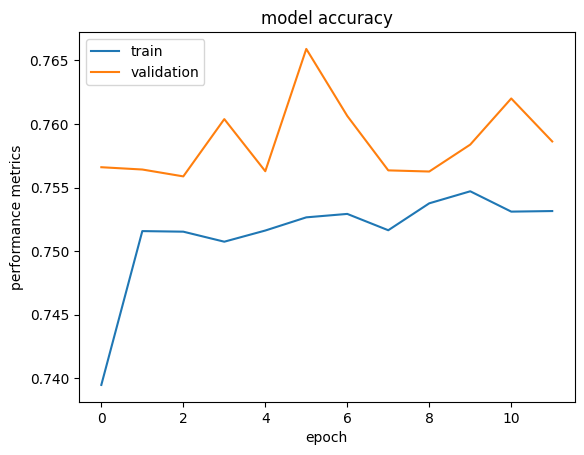

In [30]:
if BEST_SCENARIO:

  curr = df[df.ts.dt.date != max_date]
  next = df[df.ts.dt.date == max_date]

  x, y = df["embedding"], df[LABEL]

  # Getting correct sets
  x_train, y_train, x_test, y_test, x_val, y_val = get_network_sets(x, y, df)

  # Creating model
  model, callback = create_model()

  # Calculating weights for better cnn performance
  class_weights = compute_class_weight(class_weight='balanced', classes=list(set(y)), y=y)
  class_weights = {class_index: weight for class_index, weight in enumerate(class_weights)}

  # Training model
  history = model.fit(x_train, y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=([x_val, y_val]),
                      callbacks=callback,
                      class_weight=class_weights)

  # Evaluating Model
  model.evaluate(x_test, y_test, verbose=1)

  print('Train Accuracy')
  model.evaluate(x_train, y_train)
  print('Test Accuracy')
  model.evaluate(x_test, y_test)

  model.save('best_result.h5')

  plot_results(history)

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 12s - loss: 1.0892 - binary_accuracy: 0.5000 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 2s 78ms/step - loss: 0.7725 - binary_accuracy: 0.5050 - recall_m: 0.5143 - precision_m: 0.0528 - f1_m: 0.0888 - val_loss: 0.6724 - val_binary_accuracy: 0.7750 - val_recall_m: 0.5238 - val_precision_m: 0.1218 - val_f1_m: 0.1959
Epoch 2/12
1/7 [===>..........................] - ETA: 0s - loss: 0.4009 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 22ms/step - loss: 0.5796 - binary_accuracy: 0.5750 - recall_m: 0.7143 - precision_m: 0.1267 - f1_m: 0.2065 - val_loss: 0.6648 - val_binary_accuracy: 0.8050 - val_recall_m: 0.6667 - val_precision_m: 0.1627 - val_f1_m: 0.2567
Epoch 3/12
1/7 [===>..........................] - ETA: 0s - loss: 0.6053 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.0714 - f1_m: 0.1333

7/7 [==============================] - 0s 21ms/step - loss: 0.5539 - binary_accuracy: 0.5300 - recall_m: 0.7857 - precision_m: 0.0797 - f1_m: 0.1425 - val_loss: 0.6591 - val_binary_accuracy: 0.8550 - val_recall_m: 0.8571 - val_precision_m: 0.2286 - val_f1_m: 0.3571
Epoch 4/12
1/7 [===>..........................] - ETA: 0s - loss: 0.3891 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1333 - f1_m: 0.2353

7/7 [==============================] - 0s 15ms/step - loss: 0.4792 - binary_accuracy: 0.5750 - recall_m: 1.0000 - precision_m: 0.1539 - f1_m: 0.2447 - val_loss: 0.6523 - val_binary_accuracy: 0.8850 - val_recall_m: 0.8571 - val_precision_m: 0.2702 - val_f1_m: 0.4072
Epoch 5/12
1/7 [===>..........................] - ETA: 0s - loss: 0.4136 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 16ms/step - loss: 0.4630 - binary_accuracy: 0.5700 - recall_m: 0.5476 - precision_m: 0.1354 - f1_m: 0.1982 - val_loss: 0.6422 - val_binary_accuracy: 0.9500 - val_recall_m: 0.8571 - val_precision_m: 0.4881 - val_f1_m: 0.5986
Epoch 6/12
1/7 [===>..........................] - ETA: 0s - loss: 0.4237 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 14ms/step - loss: 0.3955 - binary_accuracy: 0.6450 - recall_m: 0.8571 - precision_m: 0.1098 - f1_m: 0.1934 - val_loss: 0.6322 - val_binary_accuracy: 0.9850 - val_recall_m: 0.8571 - val_precision_m: 0.6905 - val_f1_m: 0.7524
Epoch 7/12
1/7 [===>..........................] - ETA: 0s - loss: 0.4536 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 13ms/step - loss: 0.4173 - binary_accuracy: 0.6250 - recall_m: 0.7143 - precision_m: 0.1079 - f1_m: 0.1827 - val_loss: 0.6208 - val_binary_accuracy: 1.0000 - val_recall_m: 0.8571 - val_precision_m: 0.8571 - val_f1_m: 0.8571
Epoch 8/12
1/7 [===>..........................] - ETA: 0s - loss: 0.4095 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.0667 - f1_m: 0.1250

7/7 [==============================] - 0s 13ms/step - loss: 0.3928 - binary_accuracy: 0.6050 - recall_m: 0.7143 - precision_m: 0.1038 - f1_m: 0.1724 - val_loss: 0.6096 - val_binary_accuracy: 0.9950 - val_recall_m: 0.7143 - val_precision_m: 0.7143 - val_f1_m: 0.7143
Epoch 9/12
1/7 [===>..........................] - ETA: 0s - loss: 0.4041 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.0714 - f1_m: 0.1333

7/7 [==============================] - 0s 14ms/step - loss: 0.3976 - binary_accuracy: 0.6350 - recall_m: 0.8571 - precision_m: 0.1569 - f1_m: 0.2524 - val_loss: 0.5987 - val_binary_accuracy: 0.9950 - val_recall_m: 0.7143 - val_precision_m: 0.7143 - val_f1_m: 0.7143
Epoch 10/12
1/7 [===>..........................] - ETA: 0s - loss: 0.3753 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 13ms/step - loss: 0.4137 - binary_accuracy: 0.6550 - recall_m: 0.8095 - precision_m: 0.1516 - f1_m: 0.2446 - val_loss: 0.5903 - val_binary_accuracy: 1.0000 - val_recall_m: 0.8571 - val_precision_m: 0.8571 - val_f1_m: 0.8571
Epoch 11/12
1/7 [===>..........................] - ETA: 0s - loss: 0.3502 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 13ms/step - loss: 0.3737 - binary_accuracy: 0.6800 - recall_m: 0.8571 - precision_m: 0.1599 - f1_m: 0.2620 - val_loss: 0.5825 - val_binary_accuracy: 0.9950 - val_recall_m: 0.7143 - val_precision_m: 0.7143 - val_f1_m: 0.7143
Epoch 12/12
1/7 [===>..........................] - ETA: 0s - loss: 0.3662 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.0833 - f1_m: 0.1538

7/7 [==============================] - 0s 3ms/step - loss: 0.5747 - binary_accuracy: 0.9950 - recall_m: 0.7143 - precision_m: 0.7143 - f1_m: 0.7143
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.5747 - binary_accuracy: 0.9950 - recall_m: 0.7143 - precision_m: 0.7143 - f1_m: 0.7143
Test Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.5747 - binary_accuracy: 0.9950 - recall_m: 0.7143 - precision_m: 0.7143 - f1_m: 0.7143
Current date: 2022-02-22 (0/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


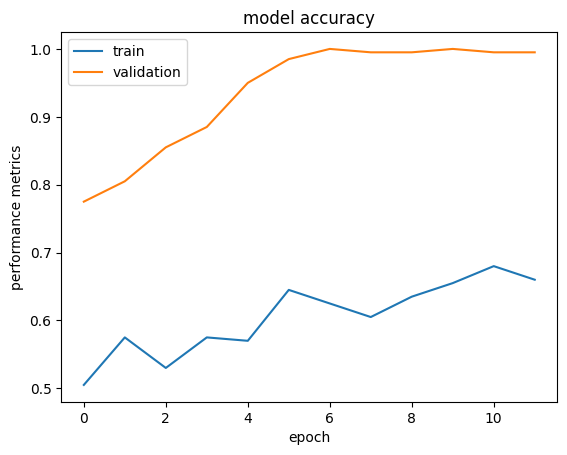

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 1/13 [=>............................] - ETA: 21s - loss: 0.8309 - binary_accuracy: 0.4688 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

13/13 [==============================] - 2s 39ms/step - loss: 0.8001 - binary_accuracy: 0.5125 - recall_m: 0.3526 - precision_m: 0.0637 - f1_m: 0.1036 - val_loss: 0.6918 - val_binary_accuracy: 0.4875 - val_recall_m: 0.6218 - val_precision_m: 0.0891 - val_f1_m: 0.1539
Epoch 2/12
 1/13 [=>............................] - ETA: 0s - loss: 0.4945 - binary_accuracy: 0.4375 - recall_m: 1.0000 - precision_m: 0.1000 - f1_m: 0.1818

13/13 [==============================] - 0s 8ms/step - loss: 0.6223 - binary_accuracy: 0.5075 - recall_m: 0.6769 - precision_m: 0.0892 - f1_m: 0.1525 - val_loss: 0.7009 - val_binary_accuracy: 0.2775 - val_recall_m: 0.8462 - val_precision_m: 0.0870 - val_f1_m: 0.1559
Epoch 3/12
 1/13 [=>............................] - ETA: 0s - loss: 0.4380 - binary_accuracy: 0.5000 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

13/13 [==============================] - 0s 12ms/step - loss: 0.5544 - binary_accuracy: 0.5300 - recall_m: 0.6795 - precision_m: 0.1084 - f1_m: 0.1806 - val_loss: 0.7022 - val_binary_accuracy: 0.2875 - val_recall_m: 0.8462 - val_precision_m: 0.0882 - val_f1_m: 0.1577
Epoch 4/12
13/13 [==============================] - ETA: 0s - loss: 0.4843 - binary_accuracy: 0.5875 - recall_m: 0.8269 - precision_m: 0.1356 - f1_m: 0.2280

13/13 [==============================] - 0s 13ms/step - loss: 0.4843 - binary_accuracy: 0.5875 - recall_m: 0.8269 - precision_m: 0.1356 - f1_m: 0.2280 - val_loss: 0.6962 - val_binary_accuracy: 0.3900 - val_recall_m: 0.8462 - val_precision_m: 0.0999 - val_f1_m: 0.1766
Epoch 5/12
 1/13 [=>............................] - ETA: 0s - loss: 0.4507 - binary_accuracy: 0.5312 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

13/13 [==============================] - 0s 9ms/step - loss: 0.4925 - binary_accuracy: 0.5900 - recall_m: 0.8205 - precision_m: 0.1331 - f1_m: 0.2207 - val_loss: 0.6874 - val_binary_accuracy: 0.5225 - val_recall_m: 0.8462 - val_precision_m: 0.1207 - val_f1_m: 0.2085
Epoch 6/12
12/13 [==========================>...] - ETA: 0s - loss: 0.4648 - binary_accuracy: 0.6094 - recall_m: 0.8167 - precision_m: 0.1312 - f1_m: 0.2130

13/13 [==============================] - 0s 13ms/step - loss: 0.4731 - binary_accuracy: 0.6100 - recall_m: 0.8308 - precision_m: 0.1321 - f1_m: 0.2158 - val_loss: 0.6755 - val_binary_accuracy: 0.6925 - val_recall_m: 0.8462 - val_precision_m: 0.1744 - val_f1_m: 0.2837
Epoch 7/12
 1/13 [=>............................] - ETA: 0s - loss: 0.4219 - binary_accuracy: 0.5625 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

13/13 [==============================] - 0s 8ms/step - loss: 0.4256 - binary_accuracy: 0.6425 - recall_m: 0.8462 - precision_m: 0.1508 - f1_m: 0.2519 - val_loss: 0.6615 - val_binary_accuracy: 0.8525 - val_recall_m: 0.8462 - val_precision_m: 0.2849 - val_f1_m: 0.4206
Epoch 8/12
 1/13 [=>............................] - ETA: 0s - loss: 0.4535 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

13/13 [==============================] - 0s 12ms/step - loss: 0.4049 - binary_accuracy: 0.6600 - recall_m: 0.8205 - precision_m: 0.1814 - f1_m: 0.2879 - val_loss: 0.6475 - val_binary_accuracy: 0.9550 - val_recall_m: 0.8462 - val_precision_m: 0.5551 - val_f1_m: 0.6616
Epoch 9/12
 1/13 [=>............................] - ETA: 0s - loss: 0.4472 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.0714 - f1_m: 0.1333

13/13 [==============================] - 0s 11ms/step - loss: 0.3764 - binary_accuracy: 0.6650 - recall_m: 0.9231 - precision_m: 0.1587 - f1_m: 0.2527 - val_loss: 0.6304 - val_binary_accuracy: 0.9850 - val_recall_m: 0.8462 - val_precision_m: 0.7500 - val_f1_m: 0.7890
Epoch 10/12
13/13 [==============================] - ETA: 0s - loss: 0.3673 - binary_accuracy: 0.7250 - recall_m: 0.9231 - precision_m: 0.2023 - f1_m: 0.3180

13/13 [==============================] - 0s 9ms/step - loss: 0.3673 - binary_accuracy: 0.7250 - recall_m: 0.9231 - precision_m: 0.2023 - f1_m: 0.3180 - val_loss: 0.6100 - val_binary_accuracy: 0.9925 - val_recall_m: 0.8205 - val_precision_m: 0.8205 - val_f1_m: 0.8154
Epoch 11/12
 1/13 [=>............................] - ETA: 0s - loss: 0.3925 - binary_accuracy: 0.5938 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

13/13 [==============================] - 0s 9ms/step - loss: 0.3419 - binary_accuracy: 0.7100 - recall_m: 0.8462 - precision_m: 0.2043 - f1_m: 0.3113 - val_loss: 0.5896 - val_binary_accuracy: 0.9975 - val_recall_m: 0.8205 - val_precision_m: 0.8462 - val_f1_m: 0.8308
Epoch 12/12
 1/13 [=>............................] - ETA: 0s - loss: 0.3903 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.4545 - f1_m: 0.6250

13/13 [==============================] - 0s 4ms/step - loss: 0.5688 - binary_accuracy: 0.9950 - recall_m: 0.8013 - precision_m: 0.8462 - f1_m: 0.8198
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
13/13 [==============================] - 0s 4ms/step - loss: 0.5688 - binary_accuracy: 0.9950 - recall_m: 0.8013 - precision_m: 0.8462 - f1_m: 0.8198
Test Accuracy
13/13 [==============================] - 0s 4ms/step - loss: 0.5688 - binary_accuracy: 0.9950 - recall_m: 0.8013 - precision_m: 0.8462 - f1_m: 0.8198
Current date: 2022-02-23 (1/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


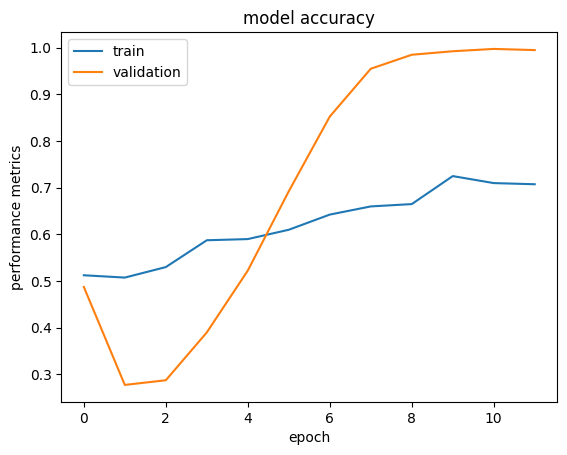

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


14/19 [=====================>........] - ETA: 0s - loss: 1.0039 - binary_accuracy: 0.4554 - recall_m: 0.3774 - precision_m: 0.0713 - f1_m: 0.1189             

19/19 [==============================] - 3s 28ms/step - loss: 0.9485 - binary_accuracy: 0.4717 - recall_m: 0.4842 - precision_m: 0.0872 - f1_m: 0.1437 - val_loss: 0.7076 - val_binary_accuracy: 0.2483 - val_recall_m: 0.9825 - val_precision_m: 0.1100 - val_f1_m: 0.1927
Epoch 2/12
15/19 [======================>.......] - ETA: 0s - loss: 0.6845 - binary_accuracy: 0.4958 - recall_m: 0.6944 - precision_m: 0.1249 - f1_m: 0.2036

19/19 [==============================] - 0s 8ms/step - loss: 0.6480 - binary_accuracy: 0.5133 - recall_m: 0.7588 - precision_m: 0.1391 - f1_m: 0.2277 - val_loss: 0.7098 - val_binary_accuracy: 0.2633 - val_recall_m: 1.0000 - val_precision_m: 0.1129 - val_f1_m: 0.1980
Epoch 3/12
14/19 [=====================>........] - ETA: 0s - loss: 0.5609 - binary_accuracy: 0.5737 - recall_m: 0.9160 - precision_m: 0.1780 - f1_m: 0.2872

19/19 [==============================] - 0s 9ms/step - loss: 0.5432 - binary_accuracy: 0.5733 - recall_m: 0.8723 - precision_m: 0.1653 - f1_m: 0.2682 - val_loss: 0.6990 - val_binary_accuracy: 0.3783 - val_recall_m: 1.0000 - val_precision_m: 0.1296 - val_f1_m: 0.2238
Epoch 4/12
15/19 [======================>.......] - ETA: 0s - loss: 0.5296 - binary_accuracy: 0.6146 - recall_m: 0.8756 - precision_m: 0.1936 - f1_m: 0.3038

19/19 [==============================] - 0s 9ms/step - loss: 0.5071 - binary_accuracy: 0.6233 - recall_m: 0.8491 - precision_m: 0.1892 - f1_m: 0.2980 - val_loss: 0.6819 - val_binary_accuracy: 0.5700 - val_recall_m: 1.0000 - val_precision_m: 0.1739 - val_f1_m: 0.2886
Epoch 5/12
15/19 [======================>.......] - ETA: 0s - loss: 0.4834 - binary_accuracy: 0.6021 - recall_m: 0.8667 - precision_m: 0.1555 - f1_m: 0.2569

19/19 [==============================] - 0s 7ms/step - loss: 0.4749 - binary_accuracy: 0.6117 - recall_m: 0.8860 - precision_m: 0.1840 - f1_m: 0.2956 - val_loss: 0.6578 - val_binary_accuracy: 0.7900 - val_recall_m: 1.0000 - val_precision_m: 0.2971 - val_f1_m: 0.4447
Epoch 6/12
14/19 [=====================>........] - ETA: 0s - loss: 0.4195 - binary_accuracy: 0.6607 - recall_m: 0.9286 - precision_m: 0.2103 - f1_m: 0.3291

19/19 [==============================] - 0s 9ms/step - loss: 0.4268 - binary_accuracy: 0.6533 - recall_m: 0.9298 - precision_m: 0.2142 - f1_m: 0.3356 - val_loss: 0.6289 - val_binary_accuracy: 0.9417 - val_recall_m: 0.9605 - val_precision_m: 0.6446 - val_f1_m: 0.7488
Epoch 7/12
15/19 [======================>.......] - ETA: 0s - loss: 0.4209 - binary_accuracy: 0.6771 - recall_m: 0.7167 - precision_m: 0.2085 - f1_m: 0.3108            

19/19 [==============================] - 0s 9ms/step - loss: 0.4122 - binary_accuracy: 0.6800 - recall_m: 0.7237 - precision_m: 0.2098 - f1_m: 0.3144 - val_loss: 0.5963 - val_binary_accuracy: 0.9817 - val_recall_m: 0.9325 - val_precision_m: 0.9000 - val_f1_m: 0.9020
Epoch 8/12
14/19 [=====================>........] - ETA: 0s - loss: 0.3613 - binary_accuracy: 0.7143 - recall_m: 0.9821 - precision_m: 0.2740 - f1_m: 0.4158

19/19 [==============================] - 0s 8ms/step - loss: 0.3635 - binary_accuracy: 0.7050 - recall_m: 0.9868 - precision_m: 0.2411 - f1_m: 0.3724 - val_loss: 0.5613 - val_binary_accuracy: 0.9800 - val_recall_m: 0.8342 - val_precision_m: 0.9649 - val_f1_m: 0.8742
Epoch 9/12
13/19 [===================>..........] - ETA: 0s - loss: 0.3451 - binary_accuracy: 0.7356 - recall_m: 0.9231 - precision_m: 0.2603 - f1_m: 0.3882

19/19 [==============================] - 0s 8ms/step - loss: 0.3451 - binary_accuracy: 0.7467 - recall_m: 0.8947 - precision_m: 0.2776 - f1_m: 0.4077 - val_loss: 0.5260 - val_binary_accuracy: 0.9683 - val_recall_m: 0.5623 - val_precision_m: 0.7368 - val_f1_m: 0.6246
Epoch 10/12
15/19 [======================>.......] - ETA: 0s - loss: 0.3212 - binary_accuracy: 0.7688 - recall_m: 1.0000 - precision_m: 0.2909 - f1_m: 0.4348

19/19 [==============================] - 0s 9ms/step - loss: 0.3186 - binary_accuracy: 0.7683 - recall_m: 1.0000 - precision_m: 0.2890 - f1_m: 0.4301 - val_loss: 0.4965 - val_binary_accuracy: 0.9600 - val_recall_m: 0.4640 - val_precision_m: 0.6842 - val_f1_m: 0.5416
Epoch 11/12
14/19 [=====================>........] - ETA: 0s - loss: 0.3235 - binary_accuracy: 0.7969 - recall_m: 0.9643 - precision_m: 0.3405 - f1_m: 0.4928

19/19 [==============================] - 0s 8ms/step - loss: 0.3250 - binary_accuracy: 0.7917 - recall_m: 0.9737 - precision_m: 0.3042 - f1_m: 0.4491 - val_loss: 0.4654 - val_binary_accuracy: 0.9717 - val_recall_m: 0.6237 - val_precision_m: 0.7368 - val_f1_m: 0.6632
Epoch 12/12
13/19 [===================>..........] - ETA: 0s - loss: 0.2702 - binary_accuracy: 0.8005 - recall_m: 1.0000 - precision_m: 0.3429 - f1_m: 0.4852

19/19 [==============================] - 0s 2ms/step - loss: 0.4311 - binary_accuracy: 0.9633 - recall_m: 0.5474 - precision_m: 0.7368 - f1_m: 0.6068
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
19/19 [==============================] - 0s 2ms/step - loss: 0.4311 - binary_accuracy: 0.9633 - recall_m: 0.5474 - precision_m: 0.7368 - f1_m: 0.6068
Test Accuracy
19/19 [==============================] - 0s 2ms/step - loss: 0.4311 - binary_accuracy: 0.9633 - recall_m: 0.5474 - precision_m: 0.7368 - f1_m: 0.6068
Current date: 2022-02-24 (2/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


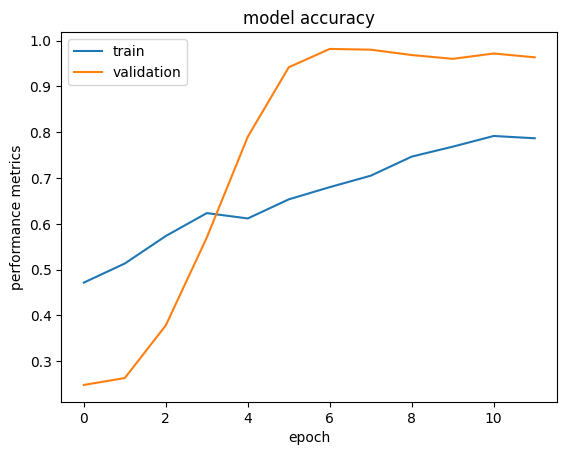

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/25 [===========================>..] - ETA: 0s - loss: 0.8482 - binary_accuracy: 0.5130 - recall_m: 0.4238 - precision_m: 0.0946 - f1_m: 0.1506

25/25 [==============================] - 2s 27ms/step - loss: 0.8398 - binary_accuracy: 0.5150 - recall_m: 0.4369 - precision_m: 0.0983 - f1_m: 0.1566 - val_loss: 0.6975 - val_binary_accuracy: 0.4013 - val_recall_m: 0.9200 - val_precision_m: 0.1476 - val_f1_m: 0.2497
Epoch 2/12
12/25 [=============>................] - ETA: 0s - loss: 0.6322 - binary_accuracy: 0.5521 - recall_m: 0.8615 - precision_m: 0.1553 - f1_m: 0.2538

25/25 [==============================] - 0s 8ms/step - loss: 0.6036 - binary_accuracy: 0.5775 - recall_m: 0.8739 - precision_m: 0.1719 - f1_m: 0.2768 - val_loss: 0.6843 - val_binary_accuracy: 0.6550 - val_recall_m: 0.9120 - val_precision_m: 0.2341 - val_f1_m: 0.3631
Epoch 3/12
13/25 [==============>...............] - ETA: 0s - loss: 0.5383 - binary_accuracy: 0.5649 - recall_m: 0.8667 - precision_m: 0.1619 - f1_m: 0.2642

25/25 [==============================] - 0s 8ms/step - loss: 0.5016 - binary_accuracy: 0.5950 - recall_m: 0.9047 - precision_m: 0.1927 - f1_m: 0.3060 - val_loss: 0.6577 - val_binary_accuracy: 0.8938 - val_recall_m: 0.8293 - val_precision_m: 0.5115 - val_f1_m: 0.6117
Epoch 4/12
12/25 [=============>................] - ETA: 0s - loss: 0.4884 - binary_accuracy: 0.6276 - recall_m: 0.9833 - precision_m: 0.2146 - f1_m: 0.3320

25/25 [==============================] - 0s 8ms/step - loss: 0.4769 - binary_accuracy: 0.6425 - recall_m: 0.9453 - precision_m: 0.2137 - f1_m: 0.3328 - val_loss: 0.6208 - val_binary_accuracy: 0.9425 - val_recall_m: 0.6200 - val_precision_m: 0.7382 - val_f1_m: 0.6486
Epoch 5/12
13/25 [==============>...............] - ETA: 0s - loss: 0.4302 - binary_accuracy: 0.6803 - recall_m: 0.8949 - precision_m: 0.2380 - f1_m: 0.3608

25/25 [==============================] - 0s 8ms/step - loss: 0.4523 - binary_accuracy: 0.6900 - recall_m: 0.8815 - precision_m: 0.2485 - f1_m: 0.3657 - val_loss: 0.5840 - val_binary_accuracy: 0.9325 - val_recall_m: 0.3920 - val_precision_m: 0.7267 - val_f1_m: 0.4855
Epoch 6/12
23/25 [==========================>...] - ETA: 0s - loss: 0.4166 - binary_accuracy: 0.7024 - recall_m: 0.9249 - precision_m: 0.2539 - f1_m: 0.3854

25/25 [==============================] - 0s 9ms/step - loss: 0.4087 - binary_accuracy: 0.7075 - recall_m: 0.9310 - precision_m: 0.2611 - f1_m: 0.3952 - val_loss: 0.5549 - val_binary_accuracy: 0.9350 - val_recall_m: 0.4053 - val_precision_m: 0.6800 - val_f1_m: 0.4915
Epoch 7/12
16/25 [==================>...........] - ETA: 0s - loss: 0.3697 - binary_accuracy: 0.7246 - recall_m: 0.8469 - precision_m: 0.2622 - f1_m: 0.3836

25/25 [==============================] - 0s 7ms/step - loss: 0.3734 - binary_accuracy: 0.7325 - recall_m: 0.9020 - precision_m: 0.2794 - f1_m: 0.4108 - val_loss: 0.5206 - val_binary_accuracy: 0.9262 - val_recall_m: 0.3093 - val_precision_m: 0.6200 - val_f1_m: 0.3952
Epoch 8/12
15/25 [=================>............] - ETA: 0s - loss: 0.3384 - binary_accuracy: 0.7771 - recall_m: 0.9611 - precision_m: 0.3490 - f1_m: 0.4980

25/25 [==============================] - 0s 7ms/step - loss: 0.3426 - binary_accuracy: 0.7688 - recall_m: 0.9767 - precision_m: 0.3129 - f1_m: 0.4546 - val_loss: 0.4832 - val_binary_accuracy: 0.9275 - val_recall_m: 0.2767 - val_precision_m: 0.6800 - val_f1_m: 0.3770
Epoch 9/12
22/25 [=========================>....] - ETA: 0s - loss: 0.3022 - binary_accuracy: 0.8182 - recall_m: 0.9264 - precision_m: 0.3456 - f1_m: 0.4828

25/25 [==============================] - 0s 9ms/step - loss: 0.2958 - binary_accuracy: 0.8250 - recall_m: 0.9352 - precision_m: 0.3688 - f1_m: 0.5086 - val_loss: 0.4460 - val_binary_accuracy: 0.9225 - val_recall_m: 0.2340 - val_precision_m: 0.6800 - val_f1_m: 0.3354
Epoch 10/12
14/25 [===============>..............] - ETA: 0s - loss: 0.3081 - binary_accuracy: 0.8281 - recall_m: 0.9643 - precision_m: 0.3785 - f1_m: 0.5069

25/25 [==============================] - 0s 8ms/step - loss: 0.2910 - binary_accuracy: 0.8313 - recall_m: 0.9800 - precision_m: 0.3734 - f1_m: 0.5083 - val_loss: 0.4142 - val_binary_accuracy: 0.9212 - val_recall_m: 0.2293 - val_precision_m: 0.6000 - val_f1_m: 0.3181
Epoch 11/12
19/25 [=====================>........] - ETA: 0s - loss: 0.3012 - binary_accuracy: 0.8224 - recall_m: 0.9688 - precision_m: 0.3734 - f1_m: 0.4933

25/25 [==============================] - 0s 10ms/step - loss: 0.2944 - binary_accuracy: 0.8325 - recall_m: 0.9763 - precision_m: 0.3936 - f1_m: 0.5221 - val_loss: 0.3783 - val_binary_accuracy: 0.9225 - val_recall_m: 0.2213 - val_precision_m: 0.5600 - val_f1_m: 0.2993
Epoch 12/12
23/25 [==========================>...] - ETA: 0s - loss: 0.2456 - binary_accuracy: 0.8560 - recall_m: 1.0000 - precision_m: 0.4329 - f1_m: 0.5621

25/25 [==============================] - 0s 3ms/step - loss: 0.3427 - binary_accuracy: 0.9337 - recall_m: 0.3520 - precision_m: 0.7600 - f1_m: 0.4580
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
25/25 [==============================] - 0s 3ms/step - loss: 0.3427 - binary_accuracy: 0.9337 - recall_m: 0.3520 - precision_m: 0.7600 - f1_m: 0.4580
Test Accuracy
25/25 [==============================] - 0s 3ms/step - loss: 0.3427 - binary_accuracy: 0.9337 - recall_m: 0.3520 - precision_m: 0.7600 - f1_m: 0.4580
Current date: 2022-02-25 (3/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


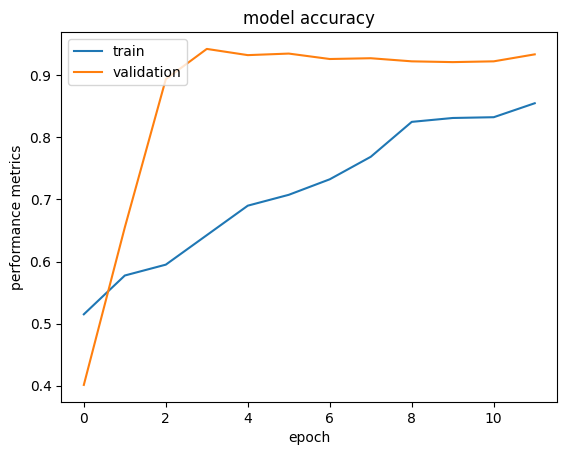

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/32 [===========================>..] - ETA: 0s - loss: 0.8849 - binary_accuracy: 0.5156 - recall_m: 0.4369 - precision_m: 0.1040 - f1_m: 0.1624

32/32 [==============================] - 3s 24ms/step - loss: 0.8735 - binary_accuracy: 0.5190 - recall_m: 0.4305 - precision_m: 0.1020 - f1_m: 0.1596 - val_loss: 0.6787 - val_binary_accuracy: 0.7550 - val_recall_m: 0.4327 - val_precision_m: 0.1855 - val_f1_m: 0.2449
Epoch 2/12
30/32 [===========================>..] - ETA: 0s - loss: 0.6057 - binary_accuracy: 0.5656 - recall_m: 0.7533 - precision_m: 0.1529 - f1_m: 0.2460

32/32 [==============================] - 0s 11ms/step - loss: 0.6061 - binary_accuracy: 0.5650 - recall_m: 0.7375 - precision_m: 0.1492 - f1_m: 0.2405 - val_loss: 0.6396 - val_binary_accuracy: 0.9140 - val_recall_m: 0.2803 - val_precision_m: 0.5385 - val_f1_m: 0.3319
Epoch 3/12
21/32 [==================>...........] - ETA: 0s - loss: 0.5447 - binary_accuracy: 0.6250 - recall_m: 0.8095 - precision_m: 0.1932 - f1_m: 0.2975

32/32 [==============================] - 0s 10ms/step - loss: 0.5489 - binary_accuracy: 0.6130 - recall_m: 0.7768 - precision_m: 0.1864 - f1_m: 0.2857 - val_loss: 0.5950 - val_binary_accuracy: 0.9130 - val_recall_m: 0.0766 - val_precision_m: 0.2656 - val_f1_m: 0.1166
Epoch 4/12
27/32 [========================>.....] - ETA: 0s - loss: 0.4642 - binary_accuracy: 0.6551 - recall_m: 0.9290 - precision_m: 0.2042 - f1_m: 0.3231

32/32 [==============================] - 0s 7ms/step - loss: 0.4739 - binary_accuracy: 0.6630 - recall_m: 0.9174 - precision_m: 0.2356 - f1_m: 0.3513 - val_loss: 0.5512 - val_binary_accuracy: 0.9140 - val_recall_m: 0.0792 - val_precision_m: 0.2500 - val_f1_m: 0.1176
Epoch 5/12
26/32 [=======================>......] - ETA: 0s - loss: 0.4298 - binary_accuracy: 0.7175 - recall_m: 0.8897 - precision_m: 0.2466 - f1_m: 0.3753

32/32 [==============================] - 0s 7ms/step - loss: 0.4316 - binary_accuracy: 0.7040 - recall_m: 0.8714 - precision_m: 0.2379 - f1_m: 0.3632 - val_loss: 0.5021 - val_binary_accuracy: 0.9070 - val_recall_m: 0.0312 - val_precision_m: 0.0937 - val_f1_m: 0.0458
Epoch 6/12
25/32 [======================>.......] - ETA: 0s - loss: 0.3993 - binary_accuracy: 0.7412 - recall_m: 0.8896 - precision_m: 0.2650 - f1_m: 0.3989

32/32 [==============================] - 0s 10ms/step - loss: 0.4063 - binary_accuracy: 0.7340 - recall_m: 0.8721 - precision_m: 0.2503 - f1_m: 0.3784 - val_loss: 0.4558 - val_binary_accuracy: 0.9070 - val_recall_m: 0.0312 - val_precision_m: 0.0937 - val_f1_m: 0.0458
Epoch 7/12
22/32 [===================>..........] - ETA: 0s - loss: 0.3722 - binary_accuracy: 0.7685 - recall_m: 0.8462 - precision_m: 0.2873 - f1_m: 0.4132

32/32 [==============================] - 0s 11ms/step - loss: 0.3566 - binary_accuracy: 0.7690 - recall_m: 0.8490 - precision_m: 0.2841 - f1_m: 0.4064 - val_loss: 0.4163 - val_binary_accuracy: 0.9060 - val_recall_m: 0.0141 - val_precision_m: 0.0625 - val_f1_m: 0.0229
Epoch 8/12
25/32 [======================>.......] - ETA: 0s - loss: 0.3667 - binary_accuracy: 0.7700 - recall_m: 0.8607 - precision_m: 0.2897 - f1_m: 0.4131

32/32 [==============================] - 0s 8ms/step - loss: 0.3576 - binary_accuracy: 0.7740 - recall_m: 0.8911 - precision_m: 0.3085 - f1_m: 0.4321 - val_loss: 0.3823 - val_binary_accuracy: 0.9080 - val_recall_m: 0.0401 - val_precision_m: 0.1250 - val_f1_m: 0.0594
Epoch 9/12
29/32 [==========================>...] - ETA: 0s - loss: 0.2962 - binary_accuracy: 0.8297 - recall_m: 0.9438 - precision_m: 0.3876 - f1_m: 0.5235

32/32 [==============================] - 0s 9ms/step - loss: 0.3046 - binary_accuracy: 0.8250 - recall_m: 0.9179 - precision_m: 0.3675 - f1_m: 0.4984 - val_loss: 0.3471 - val_binary_accuracy: 0.9070 - val_recall_m: 0.0208 - val_precision_m: 0.0937 - val_f1_m: 0.0339
Epoch 10/12
22/32 [===================>..........] - ETA: 0s - loss: 0.3216 - binary_accuracy: 0.8310 - recall_m: 0.8211 - precision_m: 0.3867 - f1_m: 0.5035

32/32 [==============================] - 0s 10ms/step - loss: 0.3141 - binary_accuracy: 0.8250 - recall_m: 0.8458 - precision_m: 0.3522 - f1_m: 0.4721 - val_loss: 0.3282 - val_binary_accuracy: 0.9250 - val_recall_m: 0.1865 - val_precision_m: 0.4375 - val_f1_m: 0.2438
Epoch 11/12
23/32 [====================>.........] - ETA: 0s - loss: 0.2917 - binary_accuracy: 0.8478 - recall_m: 0.9348 - precision_m: 0.4093 - f1_m: 0.5447

32/32 [==============================] - 0s 8ms/step - loss: 0.2834 - binary_accuracy: 0.8500 - recall_m: 0.9453 - precision_m: 0.4218 - f1_m: 0.5590 - val_loss: 0.2943 - val_binary_accuracy: 0.9410 - val_recall_m: 0.3469 - val_precision_m: 0.7187 - val_f1_m: 0.4424
Epoch 12/12
26/32 [=======================>......] - ETA: 0s - loss: 0.2560 - binary_accuracy: 0.8750 - recall_m: 0.8397 - precision_m: 0.4613 - f1_m: 0.5660

32/32 [==============================] - 0s 3ms/step - loss: 0.2627 - binary_accuracy: 0.9500 - recall_m: 0.4193 - precision_m: 0.7188 - f1_m: 0.5094
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
32/32 [==============================] - 0s 3ms/step - loss: 0.2627 - binary_accuracy: 0.9500 - recall_m: 0.4193 - precision_m: 0.7188 - f1_m: 0.5094
Test Accuracy
32/32 [==============================] - 0s 3ms/step - loss: 0.2627 - binary_accuracy: 0.9500 - recall_m: 0.4193 - precision_m: 0.7188 - f1_m: 0.5094
Current date: 2022-02-26 (4/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


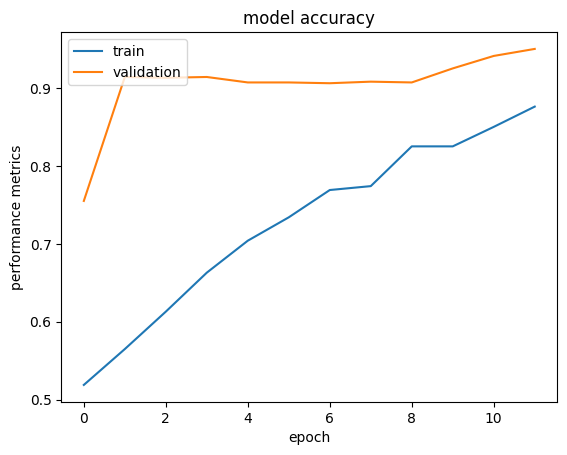

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 0.8319 - binary_accuracy: 0.5025 - recall_m: 0.5229 - precision_m: 0.1074 - f1_m: 0.1718

38/38 [==============================] - 4s 20ms/step - loss: 0.8319 - binary_accuracy: 0.5025 - recall_m: 0.5229 - precision_m: 0.1074 - f1_m: 0.1718 - val_loss: 0.6737 - val_binary_accuracy: 0.7758 - val_recall_m: 0.5964 - val_precision_m: 0.2520 - val_f1_m: 0.3393
Epoch 2/12
26/38 [===================>..........] - ETA: 0s - loss: 0.5975 - binary_accuracy: 0.5769 - recall_m: 0.7964 - precision_m: 0.1597 - f1_m: 0.2530

38/38 [==============================] - 0s 9ms/step - loss: 0.6023 - binary_accuracy: 0.5767 - recall_m: 0.7888 - precision_m: 0.1753 - f1_m: 0.2722 - val_loss: 0.6103 - val_binary_accuracy: 0.9133 - val_recall_m: 0.2089 - val_precision_m: 0.4518 - val_f1_m: 0.2677
Epoch 3/12
34/38 [=========================>....] - ETA: 0s - loss: 0.5439 - binary_accuracy: 0.6048 - recall_m: 0.8277 - precision_m: 0.1883 - f1_m: 0.2940

38/38 [==============================] - 0s 8ms/step - loss: 0.5454 - binary_accuracy: 0.6050 - recall_m: 0.8107 - precision_m: 0.1827 - f1_m: 0.2868 - val_loss: 0.5520 - val_binary_accuracy: 0.9058 - val_recall_m: 0.0652 - val_precision_m: 0.2105 - val_f1_m: 0.0966
Epoch 4/12
35/38 [==========================>...] - ETA: 0s - loss: 0.4531 - binary_accuracy: 0.6795 - recall_m: 0.9114 - precision_m: 0.2360 - f1_m: 0.3601

38/38 [==============================] - 0s 8ms/step - loss: 0.4563 - binary_accuracy: 0.6783 - recall_m: 0.9184 - precision_m: 0.2346 - f1_m: 0.3589 - val_loss: 0.4978 - val_binary_accuracy: 0.9033 - val_recall_m: 0.0439 - val_precision_m: 0.1316 - val_f1_m: 0.0649
Epoch 5/12
34/38 [=========================>....] - ETA: 0s - loss: 0.4057 - binary_accuracy: 0.7142 - recall_m: 0.8686 - precision_m: 0.2554 - f1_m: 0.3823

38/38 [==============================] - 0s 11ms/step - loss: 0.4076 - binary_accuracy: 0.7183 - recall_m: 0.8737 - precision_m: 0.2596 - f1_m: 0.3884 - val_loss: 0.4444 - val_binary_accuracy: 0.9017 - val_recall_m: 0.0241 - val_precision_m: 0.0789 - val_f1_m: 0.0368
Epoch 6/12
36/38 [===========================>..] - ETA: 0s - loss: 0.3981 - binary_accuracy: 0.7448 - recall_m: 0.9405 - precision_m: 0.2878 - f1_m: 0.4164

38/38 [==============================] - 0s 9ms/step - loss: 0.3981 - binary_accuracy: 0.7483 - recall_m: 0.9305 - precision_m: 0.2964 - f1_m: 0.4226 - val_loss: 0.3987 - val_binary_accuracy: 0.9025 - val_recall_m: 0.0307 - val_precision_m: 0.1053 - val_f1_m: 0.0474
Epoch 7/12
37/38 [============================>.] - ETA: 0s - loss: 0.3514 - binary_accuracy: 0.7829 - recall_m: 0.9180 - precision_m: 0.3370 - f1_m: 0.4706

38/38 [==============================] - 0s 7ms/step - loss: 0.3514 - binary_accuracy: 0.7825 - recall_m: 0.8939 - precision_m: 0.3282 - f1_m: 0.4582 - val_loss: 0.3606 - val_binary_accuracy: 0.9058 - val_recall_m: 0.0702 - val_precision_m: 0.2105 - val_f1_m: 0.1035
Epoch 8/12
28/38 [=====================>........] - ETA: 0s - loss: 0.3402 - binary_accuracy: 0.8069 - recall_m: 0.9341 - precision_m: 0.3440 - f1_m: 0.4645

38/38 [==============================] - 0s 9ms/step - loss: 0.3392 - binary_accuracy: 0.8083 - recall_m: 0.9449 - precision_m: 0.3442 - f1_m: 0.4696 - val_loss: 0.3246 - val_binary_accuracy: 0.9117 - val_recall_m: 0.1121 - val_precision_m: 0.3421 - val_f1_m: 0.1623
Epoch 9/12
37/38 [============================>.] - ETA: 0s - loss: 0.3282 - binary_accuracy: 0.8142 - recall_m: 0.8712 - precision_m: 0.3527 - f1_m: 0.4675

38/38 [==============================] - 0s 9ms/step - loss: 0.3269 - binary_accuracy: 0.8142 - recall_m: 0.8746 - precision_m: 0.3540 - f1_m: 0.4702 - val_loss: 0.2888 - val_binary_accuracy: 0.9158 - val_recall_m: 0.1970 - val_precision_m: 0.4868 - val_f1_m: 0.2610
Epoch 10/12
38/38 [==============================] - ETA: 0s - loss: 0.3034 - binary_accuracy: 0.8425 - recall_m: 0.9224 - precision_m: 0.4100 - f1_m: 0.5386

38/38 [==============================] - 0s 7ms/step - loss: 0.3034 - binary_accuracy: 0.8425 - recall_m: 0.9224 - precision_m: 0.4100 - f1_m: 0.5386 - val_loss: 0.2573 - val_binary_accuracy: 0.9383 - val_recall_m: 0.3936 - val_precision_m: 0.7675 - val_f1_m: 0.4964
Epoch 11/12
27/38 [====================>.........] - ETA: 0s - loss: 0.2750 - binary_accuracy: 0.8426 - recall_m: 0.9348 - precision_m: 0.4024 - f1_m: 0.5274

38/38 [==============================] - 0s 9ms/step - loss: 0.2766 - binary_accuracy: 0.8425 - recall_m: 0.9449 - precision_m: 0.3909 - f1_m: 0.5203 - val_loss: 0.2232 - val_binary_accuracy: 0.9550 - val_recall_m: 0.5544 - val_precision_m: 0.8596 - val_f1_m: 0.6431
Epoch 12/12
25/38 [==================>...........] - ETA: 0s - loss: 0.2712 - binary_accuracy: 0.8775 - recall_m: 0.8627 - precision_m: 0.4805 - f1_m: 0.5840

38/38 [==============================] - 0s 2ms/step - loss: 0.1946 - binary_accuracy: 0.9742 - recall_m: 0.7699 - precision_m: 0.9171 - f1_m: 0.8132
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
38/38 [==============================] - 0s 2ms/step - loss: 0.1946 - binary_accuracy: 0.9742 - recall_m: 0.7699 - precision_m: 0.9171 - f1_m: 0.8132
Test Accuracy
38/38 [==============================] - 0s 4ms/step - loss: 0.1946 - binary_accuracy: 0.9742 - recall_m: 0.7699 - precision_m: 0.9171 - f1_m: 0.8132
Current date: 2022-02-27 (5/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


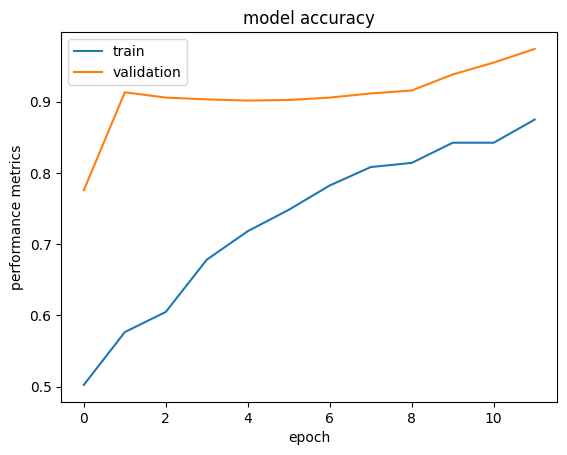

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


43/44 [============================>.] - ETA: 0s - loss: 0.7410 - binary_accuracy: 0.5036 - recall_m: 0.6267 - precision_m: 0.1114 - f1_m: 0.1811

44/44 [==============================] - 4s 30ms/step - loss: 0.7432 - binary_accuracy: 0.5057 - recall_m: 0.6261 - precision_m: 0.1157 - f1_m: 0.1861 - val_loss: 0.6946 - val_binary_accuracy: 0.4593 - val_recall_m: 0.9337 - val_precision_m: 0.1505 - val_f1_m: 0.2514
Epoch 2/12
44/44 [==============================] - ETA: 0s - loss: 0.5975 - binary_accuracy: 0.5521 - recall_m: 0.7577 - precision_m: 0.1561 - f1_m: 0.2504

44/44 [==============================] - 1s 13ms/step - loss: 0.5975 - binary_accuracy: 0.5521 - recall_m: 0.7577 - precision_m: 0.1561 - f1_m: 0.2504 - val_loss: 0.6809 - val_binary_accuracy: 0.6043 - val_recall_m: 0.9261 - val_precision_m: 0.1951 - val_f1_m: 0.3114
Epoch 3/12
30/44 [===================>..........] - ETA: 0s - loss: 0.5222 - binary_accuracy: 0.6073 - recall_m: 0.8317 - precision_m: 0.1801 - f1_m: 0.2891

44/44 [==============================] - 0s 6ms/step - loss: 0.5293 - binary_accuracy: 0.6150 - recall_m: 0.8227 - precision_m: 0.1884 - f1_m: 0.2989 - val_loss: 0.6480 - val_binary_accuracy: 0.8093 - val_recall_m: 0.8629 - val_precision_m: 0.3310 - val_f1_m: 0.4614
Epoch 4/12
41/44 [==========================>...] - ETA: 0s - loss: 0.4677 - binary_accuracy: 0.6555 - recall_m: 0.8837 - precision_m: 0.2052 - f1_m: 0.3218

44/44 [==============================] - 0s 8ms/step - loss: 0.4708 - binary_accuracy: 0.6536 - recall_m: 0.8841 - precision_m: 0.2072 - f1_m: 0.3249 - val_loss: 0.5989 - val_binary_accuracy: 0.9250 - val_recall_m: 0.7167 - val_precision_m: 0.5831 - val_f1_m: 0.6205
Epoch 5/12
39/44 [=========================>....] - ETA: 0s - loss: 0.4400 - binary_accuracy: 0.6899 - recall_m: 0.9378 - precision_m: 0.2335 - f1_m: 0.3589

44/44 [==============================] - 0s 8ms/step - loss: 0.4470 - binary_accuracy: 0.6843 - recall_m: 0.9089 - precision_m: 0.2293 - f1_m: 0.3527 - val_loss: 0.5462 - val_binary_accuracy: 0.9436 - val_recall_m: 0.6229 - val_precision_m: 0.7127 - val_f1_m: 0.6349
Epoch 6/12
40/44 [==========================>...] - ETA: 0s - loss: 0.4036 - binary_accuracy: 0.7289 - recall_m: 0.8725 - precision_m: 0.2596 - f1_m: 0.3826

44/44 [==============================] - 0s 8ms/step - loss: 0.4105 - binary_accuracy: 0.7264 - recall_m: 0.8386 - precision_m: 0.2555 - f1_m: 0.3746 - val_loss: 0.4852 - val_binary_accuracy: 0.9371 - val_recall_m: 0.4267 - val_precision_m: 0.6739 - val_f1_m: 0.5014
Epoch 7/12
38/44 [========================>.....] - ETA: 0s - loss: 0.3701 - binary_accuracy: 0.7730 - recall_m: 0.9254 - precision_m: 0.3027 - f1_m: 0.4433

44/44 [==============================] - 0s 9ms/step - loss: 0.3684 - binary_accuracy: 0.7721 - recall_m: 0.9242 - precision_m: 0.2971 - f1_m: 0.4358 - val_loss: 0.4321 - val_binary_accuracy: 0.9393 - val_recall_m: 0.4511 - val_precision_m: 0.7788 - val_f1_m: 0.5463
Epoch 8/12
44/44 [==============================] - ETA: 0s - loss: 0.3663 - binary_accuracy: 0.7793 - recall_m: 0.8869 - precision_m: 0.3162 - f1_m: 0.4419

44/44 [==============================] - 0s 9ms/step - loss: 0.3663 - binary_accuracy: 0.7793 - recall_m: 0.8869 - precision_m: 0.3162 - f1_m: 0.4419 - val_loss: 0.3862 - val_binary_accuracy: 0.9464 - val_recall_m: 0.5360 - val_precision_m: 0.8136 - val_f1_m: 0.6215
Epoch 9/12
41/44 [==========================>...] - ETA: 0s - loss: 0.3157 - binary_accuracy: 0.8140 - recall_m: 0.8992 - precision_m: 0.3302 - f1_m: 0.4613

44/44 [==============================] - 0s 10ms/step - loss: 0.3240 - binary_accuracy: 0.8186 - recall_m: 0.8967 - precision_m: 0.3483 - f1_m: 0.4736 - val_loss: 0.3180 - val_binary_accuracy: 0.9414 - val_recall_m: 0.4178 - val_precision_m: 0.7777 - val_f1_m: 0.5230
Epoch 10/12
35/44 [======================>.......] - ETA: 0s - loss: 0.2942 - binary_accuracy: 0.8491 - recall_m: 0.9076 - precision_m: 0.3982 - f1_m: 0.5214

44/44 [==============================] - 0s 9ms/step - loss: 0.3054 - binary_accuracy: 0.8450 - recall_m: 0.8985 - precision_m: 0.3936 - f1_m: 0.5165 - val_loss: 0.2960 - val_binary_accuracy: 0.9671 - val_recall_m: 0.7867 - val_precision_m: 0.8294 - val_f1_m: 0.7827
Epoch 11/12
44/44 [==============================] - ETA: 0s - loss: 0.2928 - binary_accuracy: 0.8557 - recall_m: 0.8905 - precision_m: 0.4188 - f1_m: 0.5389

44/44 [==============================] - 0s 9ms/step - loss: 0.2928 - binary_accuracy: 0.8557 - recall_m: 0.8905 - precision_m: 0.4188 - f1_m: 0.5389 - val_loss: 0.2384 - val_binary_accuracy: 0.9750 - val_recall_m: 0.8407 - val_precision_m: 0.8971 - val_f1_m: 0.8467
Epoch 12/12
39/44 [=========================>....] - ETA: 0s - loss: 0.2725 - binary_accuracy: 0.8790 - recall_m: 0.8673 - precision_m: 0.4438 - f1_m: 0.5567

44/44 [==============================] - 0s 3ms/step - loss: 0.2110 - binary_accuracy: 0.9829 - recall_m: 0.9462 - precision_m: 0.8867 - f1_m: 0.9014
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
44/44 [==============================] - 0s 2ms/step - loss: 0.2110 - binary_accuracy: 0.9829 - recall_m: 0.9462 - precision_m: 0.8867 - f1_m: 0.9014
Test Accuracy
44/44 [==============================] - 0s 3ms/step - loss: 0.2110 - binary_accuracy: 0.9829 - recall_m: 0.9462 - precision_m: 0.8867 - f1_m: 0.9014
Current date: 2022-02-28 (6/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


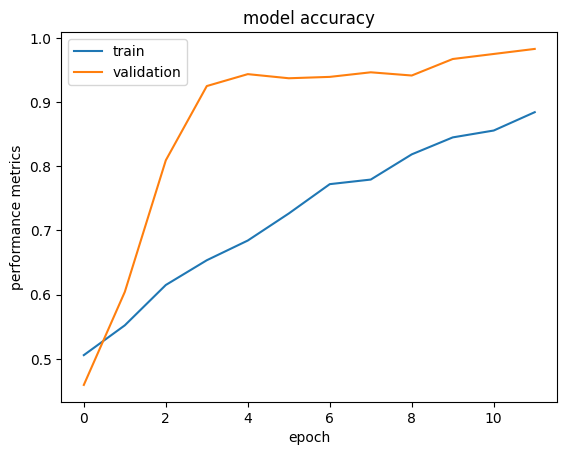

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


45/50 [==========================>...] - ETA: 0s - loss: 0.8148 - binary_accuracy: 0.4931 - recall_m: 0.5311 - precision_m: 0.1115 - f1_m: 0.1796

50/50 [==============================] - 3s 23ms/step - loss: 0.8182 - binary_accuracy: 0.4913 - recall_m: 0.5080 - precision_m: 0.1064 - f1_m: 0.1716 - val_loss: 0.6867 - val_binary_accuracy: 0.5875 - val_recall_m: 0.8173 - val_precision_m: 0.1798 - val_f1_m: 0.2838
Epoch 2/12
42/50 [========================>.....] - ETA: 0s - loss: 0.6093 - binary_accuracy: 0.5714 - recall_m: 0.8087 - precision_m: 0.1691 - f1_m: 0.2722

50/50 [==============================] - 0s 9ms/step - loss: 0.6155 - binary_accuracy: 0.5781 - recall_m: 0.8067 - precision_m: 0.1744 - f1_m: 0.2791 - val_loss: 0.6537 - val_binary_accuracy: 0.8306 - val_recall_m: 0.7330 - val_precision_m: 0.3560 - val_f1_m: 0.4534
Epoch 3/12
46/50 [==========================>...] - ETA: 0s - loss: 0.5224 - binary_accuracy: 0.6359 - recall_m: 0.7678 - precision_m: 0.1989 - f1_m: 0.3039

50/50 [==============================] - 0s 9ms/step - loss: 0.5211 - binary_accuracy: 0.6338 - recall_m: 0.7530 - precision_m: 0.1925 - f1_m: 0.2953 - val_loss: 0.6097 - val_binary_accuracy: 0.9094 - val_recall_m: 0.4256 - val_precision_m: 0.5366 - val_f1_m: 0.4267
Epoch 4/12
50/50 [==============================] - ETA: 0s - loss: 0.5057 - binary_accuracy: 0.6775 - recall_m: 0.8710 - precision_m: 0.2296 - f1_m: 0.3488

50/50 [==============================] - 0s 9ms/step - loss: 0.5057 - binary_accuracy: 0.6775 - recall_m: 0.8710 - precision_m: 0.2296 - f1_m: 0.3488 - val_loss: 0.5589 - val_binary_accuracy: 0.9219 - val_recall_m: 0.3910 - val_precision_m: 0.6086 - val_f1_m: 0.4442
Epoch 5/12
50/50 [==============================] - ETA: 0s - loss: 0.4448 - binary_accuracy: 0.7144 - recall_m: 0.8777 - precision_m: 0.2566 - f1_m: 0.3810

50/50 [==============================] - 1s 14ms/step - loss: 0.4448 - binary_accuracy: 0.7144 - recall_m: 0.8777 - precision_m: 0.2566 - f1_m: 0.3810 - val_loss: 0.5009 - val_binary_accuracy: 0.9206 - val_recall_m: 0.2717 - val_precision_m: 0.5487 - val_f1_m: 0.3485
Epoch 6/12
44/50 [=========================>....] - ETA: 0s - loss: 0.4153 - binary_accuracy: 0.7493 - recall_m: 0.8961 - precision_m: 0.2894 - f1_m: 0.4158

50/50 [==============================] - 1s 11ms/step - loss: 0.4079 - binary_accuracy: 0.7556 - recall_m: 0.8986 - precision_m: 0.2944 - f1_m: 0.4199 - val_loss: 0.4503 - val_binary_accuracy: 0.9281 - val_recall_m: 0.3330 - val_precision_m: 0.6333 - val_f1_m: 0.4108
Epoch 7/12
48/50 [===========================>..] - ETA: 0s - loss: 0.3725 - binary_accuracy: 0.7891 - recall_m: 0.9078 - precision_m: 0.3327 - f1_m: 0.4667

50/50 [==============================] - 0s 8ms/step - loss: 0.3728 - binary_accuracy: 0.7887 - recall_m: 0.9115 - precision_m: 0.3313 - f1_m: 0.4661 - val_loss: 0.3899 - val_binary_accuracy: 0.9362 - val_recall_m: 0.4019 - val_precision_m: 0.6596 - val_f1_m: 0.4777
Epoch 8/12
38/50 [=====================>........] - ETA: 0s - loss: 0.3356 - binary_accuracy: 0.8174 - recall_m: 0.8180 - precision_m: 0.3477 - f1_m: 0.4622

50/50 [==============================] - 0s 6ms/step - loss: 0.3554 - binary_accuracy: 0.8144 - recall_m: 0.8310 - precision_m: 0.3569 - f1_m: 0.4735 - val_loss: 0.3472 - val_binary_accuracy: 0.9525 - val_recall_m: 0.6236 - val_precision_m: 0.8066 - val_f1_m: 0.6706
Epoch 9/12
41/50 [=======================>......] - ETA: 0s - loss: 0.3261 - binary_accuracy: 0.8277 - recall_m: 0.8617 - precision_m: 0.3656 - f1_m: 0.4876

50/50 [==============================] - 0s 6ms/step - loss: 0.3259 - binary_accuracy: 0.8281 - recall_m: 0.8750 - precision_m: 0.3728 - f1_m: 0.4959 - val_loss: 0.2933 - val_binary_accuracy: 0.9669 - val_recall_m: 0.7533 - val_precision_m: 0.8429 - val_f1_m: 0.7763
Epoch 10/12
48/50 [===========================>..] - ETA: 0s - loss: 0.2812 - binary_accuracy: 0.8568 - recall_m: 0.9604 - precision_m: 0.4420 - f1_m: 0.5748

50/50 [==============================] - 0s 9ms/step - loss: 0.2777 - binary_accuracy: 0.8575 - recall_m: 0.9620 - precision_m: 0.4432 - f1_m: 0.5774 - val_loss: 0.2381 - val_binary_accuracy: 0.9781 - val_recall_m: 0.8435 - val_precision_m: 0.8798 - val_f1_m: 0.8459
Epoch 11/12
46/50 [==========================>...] - ETA: 0s - loss: 0.2644 - binary_accuracy: 0.8832 - recall_m: 0.9435 - precision_m: 0.4812 - f1_m: 0.6123

50/50 [==============================] - 0s 9ms/step - loss: 0.2643 - binary_accuracy: 0.8781 - recall_m: 0.9480 - precision_m: 0.4693 - f1_m: 0.6020 - val_loss: 0.2114 - val_binary_accuracy: 0.9812 - val_recall_m: 0.9233 - val_precision_m: 0.8485 - val_f1_m: 0.8678
Epoch 12/12
49/50 [============================>.] - ETA: 0s - loss: 0.2428 - binary_accuracy: 0.8948 - recall_m: 0.9363 - precision_m: 0.4972 - f1_m: 0.6183

50/50 [==============================] - 0s 3ms/step - loss: 0.1644 - binary_accuracy: 0.9869 - recall_m: 0.9417 - precision_m: 0.8893 - f1_m: 0.9056
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
50/50 [==============================] - 0s 4ms/step - loss: 0.1644 - binary_accuracy: 0.9869 - recall_m: 0.9417 - precision_m: 0.8893 - f1_m: 0.9056
Test Accuracy
50/50 [==============================] - 0s 3ms/step - loss: 0.1644 - binary_accuracy: 0.9869 - recall_m: 0.9417 - precision_m: 0.8893 - f1_m: 0.9056
Current date: 2022-03-01 (7/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


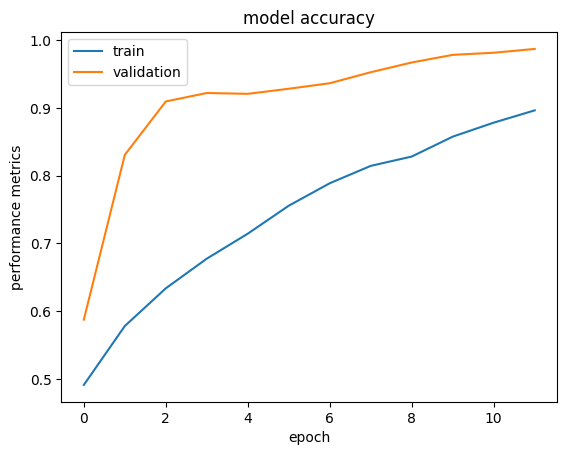

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


43/57 [=====================>........] - ETA: 0s - loss: 0.7802 - binary_accuracy: 0.5647 - recall_m: 0.5557 - precision_m: 0.1551 - f1_m: 0.2337

57/57 [==============================] - 3s 13ms/step - loss: 0.7575 - binary_accuracy: 0.5694 - recall_m: 0.5830 - precision_m: 0.1503 - f1_m: 0.2306 - val_loss: 0.6483 - val_binary_accuracy: 0.8639 - val_recall_m: 0.4329 - val_precision_m: 0.3938 - val_f1_m: 0.3859
Epoch 2/12
47/57 [=======================>......] - ETA: 0s - loss: 0.5766 - binary_accuracy: 0.6356 - recall_m: 0.8066 - precision_m: 0.2224 - f1_m: 0.3371

57/57 [==============================] - 0s 7ms/step - loss: 0.5710 - binary_accuracy: 0.6344 - recall_m: 0.7648 - precision_m: 0.2098 - f1_m: 0.3188 - val_loss: 0.5601 - val_binary_accuracy: 0.8889 - val_recall_m: 0.0386 - val_precision_m: 0.1053 - val_f1_m: 0.0556
Epoch 3/12
49/57 [========================>.....] - ETA: 0s - loss: 0.5113 - binary_accuracy: 0.6920 - recall_m: 0.8122 - precision_m: 0.2472 - f1_m: 0.3667

57/57 [==============================] - 0s 7ms/step - loss: 0.5149 - binary_accuracy: 0.6961 - recall_m: 0.8044 - precision_m: 0.2497 - f1_m: 0.3677 - val_loss: 0.4896 - val_binary_accuracy: 0.8894 - val_recall_m: 0.0298 - val_precision_m: 0.0877 - val_f1_m: 0.0430
Epoch 4/12
52/57 [==========================>...] - ETA: 0s - loss: 0.4962 - binary_accuracy: 0.7157 - recall_m: 0.8169 - precision_m: 0.2628 - f1_m: 0.3818

57/57 [==============================] - 0s 7ms/step - loss: 0.4992 - binary_accuracy: 0.7194 - recall_m: 0.8000 - precision_m: 0.2670 - f1_m: 0.3844 - val_loss: 0.4380 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0382 - val_precision_m: 0.1140 - val_f1_m: 0.0556
Epoch 5/12
51/57 [=========================>....] - ETA: 0s - loss: 0.4558 - binary_accuracy: 0.7488 - recall_m: 0.8761 - precision_m: 0.2964 - f1_m: 0.4261

57/57 [==============================] - 0s 7ms/step - loss: 0.4527 - binary_accuracy: 0.7478 - recall_m: 0.8798 - precision_m: 0.2971 - f1_m: 0.4286 - val_loss: 0.3921 - val_binary_accuracy: 0.8956 - val_recall_m: 0.0896 - val_precision_m: 0.2719 - val_f1_m: 0.1306
Epoch 6/12
51/57 [=========================>....] - ETA: 0s - loss: 0.4166 - binary_accuracy: 0.7874 - recall_m: 0.8527 - precision_m: 0.3463 - f1_m: 0.4678

57/57 [==============================] - 0s 7ms/step - loss: 0.4120 - binary_accuracy: 0.7878 - recall_m: 0.8609 - precision_m: 0.3462 - f1_m: 0.4702 - val_loss: 0.3508 - val_binary_accuracy: 0.9056 - val_recall_m: 0.1666 - val_precision_m: 0.4152 - val_f1_m: 0.2253
Epoch 7/12
50/57 [=========================>....] - ETA: 0s - loss: 0.3827 - binary_accuracy: 0.7962 - recall_m: 0.9092 - precision_m: 0.3643 - f1_m: 0.5022

57/57 [==============================] - 0s 8ms/step - loss: 0.3784 - binary_accuracy: 0.7944 - recall_m: 0.8941 - precision_m: 0.3545 - f1_m: 0.4901 - val_loss: 0.3041 - val_binary_accuracy: 0.9139 - val_recall_m: 0.2577 - val_precision_m: 0.5336 - val_f1_m: 0.3272
Epoch 8/12
50/57 [=========================>....] - ETA: 0s - loss: 0.3316 - binary_accuracy: 0.8531 - recall_m: 0.9375 - precision_m: 0.4436 - f1_m: 0.5801

57/57 [==============================] - 0s 9ms/step - loss: 0.3307 - binary_accuracy: 0.8511 - recall_m: 0.9247 - precision_m: 0.4339 - f1_m: 0.5703 - val_loss: 0.2596 - val_binary_accuracy: 0.9378 - val_recall_m: 0.4789 - val_precision_m: 0.7626 - val_f1_m: 0.5566
Epoch 9/12
46/57 [=======================>......] - ETA: 0s - loss: 0.3113 - binary_accuracy: 0.8526 - recall_m: 0.9348 - precision_m: 0.4237 - f1_m: 0.5581

57/57 [==============================] - 0s 8ms/step - loss: 0.3049 - binary_accuracy: 0.8567 - recall_m: 0.9424 - precision_m: 0.4442 - f1_m: 0.5769 - val_loss: 0.2164 - val_binary_accuracy: 0.9589 - val_recall_m: 0.6736 - val_precision_m: 0.8666 - val_f1_m: 0.7316
Epoch 10/12
50/57 [=========================>....] - ETA: 0s - loss: 0.3036 - binary_accuracy: 0.8656 - recall_m: 0.9335 - precision_m: 0.4732 - f1_m: 0.6007

57/57 [==============================] - 0s 7ms/step - loss: 0.2980 - binary_accuracy: 0.8656 - recall_m: 0.9030 - precision_m: 0.4570 - f1_m: 0.5782 - val_loss: 0.1894 - val_binary_accuracy: 0.9811 - val_recall_m: 0.9428 - val_precision_m: 0.8666 - val_f1_m: 0.8903
Epoch 11/12
50/57 [=========================>....] - ETA: 0s - loss: 0.2706 - binary_accuracy: 0.8888 - recall_m: 0.9357 - precision_m: 0.5223 - f1_m: 0.6418

57/57 [==============================] - 0s 8ms/step - loss: 0.2740 - binary_accuracy: 0.8844 - recall_m: 0.9085 - precision_m: 0.4997 - f1_m: 0.6166 - val_loss: 0.1606 - val_binary_accuracy: 0.9806 - val_recall_m: 0.9501 - val_precision_m: 0.8485 - val_f1_m: 0.8869
Epoch 12/12
55/57 [===========================>..] - ETA: 0s - loss: 0.2473 - binary_accuracy: 0.8994 - recall_m: 0.9581 - precision_m: 0.5507 - f1_m: 0.6605

57/57 [==============================] - 0s 2ms/step - loss: 0.1373 - binary_accuracy: 0.9806 - recall_m: 0.9746 - precision_m: 0.8483 - f1_m: 0.8957
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
57/57 [==============================] - 0s 2ms/step - loss: 0.1373 - binary_accuracy: 0.9806 - recall_m: 0.9746 - precision_m: 0.8483 - f1_m: 0.8957
Test Accuracy
57/57 [==============================] - 0s 2ms/step - loss: 0.1373 - binary_accuracy: 0.9806 - recall_m: 0.9746 - precision_m: 0.8483 - f1_m: 0.8957
Current date: 2022-03-02 (8/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


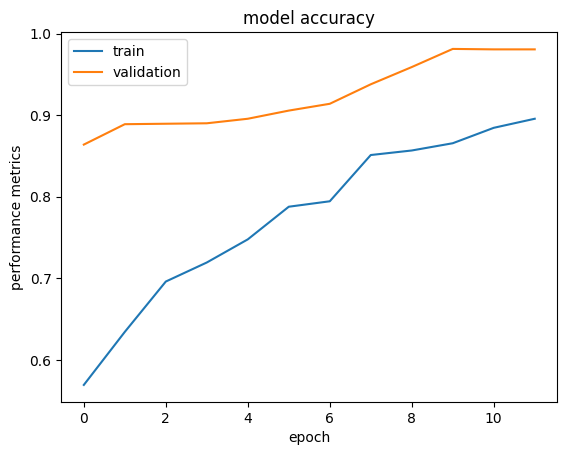

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


60/63 [===========================>..] - ETA: 0s - loss: 0.8558 - binary_accuracy: 0.5479 - recall_m: 0.6174 - precision_m: 0.1625 - f1_m: 0.2517

63/63 [==============================] - 3s 21ms/step - loss: 0.8472 - binary_accuracy: 0.5485 - recall_m: 0.6197 - precision_m: 0.1604 - f1_m: 0.2488 - val_loss: 0.5808 - val_binary_accuracy: 0.8765 - val_recall_m: 0.0277 - val_precision_m: 0.0952 - val_f1_m: 0.0410
Epoch 2/12
63/63 [==============================] - ETA: 0s - loss: 0.6138 - binary_accuracy: 0.6280 - recall_m: 0.8155 - precision_m: 0.2270 - f1_m: 0.3457

63/63 [==============================] - 1s 12ms/step - loss: 0.6138 - binary_accuracy: 0.6280 - recall_m: 0.8155 - precision_m: 0.2270 - f1_m: 0.3457 - val_loss: 0.4620 - val_binary_accuracy: 0.8755 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/12
58/63 [==========================>...] - ETA: 0s - loss: 0.5475 - binary_accuracy: 0.6697 - recall_m: 0.8447 - precision_m: 0.2542 - f1_m: 0.3757

63/63 [==============================] - 1s 10ms/step - loss: 0.5627 - binary_accuracy: 0.6665 - recall_m: 0.8256 - precision_m: 0.2494 - f1_m: 0.3682 - val_loss: 0.4025 - val_binary_accuracy: 0.8755 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/12
63/63 [==============================] - ETA: 0s - loss: 0.4924 - binary_accuracy: 0.7060 - recall_m: 0.8479 - precision_m: 0.2832 - f1_m: 0.4114

63/63 [==============================] - 1s 12ms/step - loss: 0.4924 - binary_accuracy: 0.7060 - recall_m: 0.8479 - precision_m: 0.2832 - f1_m: 0.4114 - val_loss: 0.3609 - val_binary_accuracy: 0.8760 - val_recall_m: 0.0079 - val_precision_m: 0.0159 - val_f1_m: 0.0106
Epoch 5/12
60/63 [===========================>..] - ETA: 0s - loss: 0.4457 - binary_accuracy: 0.7297 - recall_m: 0.9104 - precision_m: 0.3057 - f1_m: 0.4373

63/63 [==============================] - 1s 10ms/step - loss: 0.4522 - binary_accuracy: 0.7310 - recall_m: 0.8991 - precision_m: 0.3093 - f1_m: 0.4392 - val_loss: 0.3246 - val_binary_accuracy: 0.8840 - val_recall_m: 0.0720 - val_precision_m: 0.2381 - val_f1_m: 0.1064
Epoch 6/12
58/63 [==========================>...] - ETA: 0s - loss: 0.4146 - binary_accuracy: 0.7710 - recall_m: 0.9047 - precision_m: 0.3493 - f1_m: 0.4748

63/63 [==============================] - 1s 8ms/step - loss: 0.4118 - binary_accuracy: 0.7715 - recall_m: 0.9038 - precision_m: 0.3503 - f1_m: 0.4766 - val_loss: 0.2868 - val_binary_accuracy: 0.8935 - val_recall_m: 0.1548 - val_precision_m: 0.4921 - val_f1_m: 0.2285
Epoch 7/12
61/63 [============================>.] - ETA: 0s - loss: 0.3703 - binary_accuracy: 0.8023 - recall_m: 0.9231 - precision_m: 0.3822 - f1_m: 0.5182

63/63 [==============================] - 1s 8ms/step - loss: 0.3682 - binary_accuracy: 0.8035 - recall_m: 0.9256 - precision_m: 0.3855 - f1_m: 0.5223 - val_loss: 0.2550 - val_binary_accuracy: 0.9330 - val_recall_m: 0.4721 - val_precision_m: 0.7989 - val_f1_m: 0.5708
Epoch 8/12
62/63 [============================>.] - ETA: 0s - loss: 0.3571 - binary_accuracy: 0.8231 - recall_m: 0.8802 - precision_m: 0.4132 - f1_m: 0.5405

63/63 [==============================] - 1s 8ms/step - loss: 0.3566 - binary_accuracy: 0.8235 - recall_m: 0.8821 - precision_m: 0.4119 - f1_m: 0.5399 - val_loss: 0.2231 - val_binary_accuracy: 0.9520 - val_recall_m: 0.7154 - val_precision_m: 0.8295 - val_f1_m: 0.7451
Epoch 9/12
60/63 [===========================>..] - ETA: 0s - loss: 0.3152 - binary_accuracy: 0.8484 - recall_m: 0.8908 - precision_m: 0.4553 - f1_m: 0.5811

63/63 [==============================] - 1s 8ms/step - loss: 0.3138 - binary_accuracy: 0.8490 - recall_m: 0.8960 - precision_m: 0.4558 - f1_m: 0.5837 - val_loss: 0.1915 - val_binary_accuracy: 0.9715 - val_recall_m: 0.8846 - val_precision_m: 0.8492 - val_f1_m: 0.8520
Epoch 10/12
61/63 [============================>.] - ETA: 0s - loss: 0.3023 - binary_accuracy: 0.8550 - recall_m: 0.9584 - precision_m: 0.4747 - f1_m: 0.5914

63/63 [==============================] - 0s 7ms/step - loss: 0.3048 - binary_accuracy: 0.8540 - recall_m: 0.9545 - precision_m: 0.4750 - f1_m: 0.5905 - val_loss: 0.1609 - val_binary_accuracy: 0.9765 - val_recall_m: 0.9661 - val_precision_m: 0.8416 - val_f1_m: 0.8872
Epoch 11/12
63/63 [==============================] - ETA: 0s - loss: 0.2788 - binary_accuracy: 0.8640 - recall_m: 0.9357 - precision_m: 0.4938 - f1_m: 0.6203

63/63 [==============================] - 0s 7ms/step - loss: 0.2788 - binary_accuracy: 0.8640 - recall_m: 0.9357 - precision_m: 0.4938 - f1_m: 0.6203 - val_loss: 0.1446 - val_binary_accuracy: 0.9790 - val_recall_m: 0.9782 - val_precision_m: 0.8470 - val_f1_m: 0.8951
Epoch 12/12
53/63 [========================>.....] - ETA: 0s - loss: 0.2511 - binary_accuracy: 0.8785 - recall_m: 0.9704 - precision_m: 0.5068 - f1_m: 0.6380

63/63 [==============================] - 0s 2ms/step - loss: 0.1228 - binary_accuracy: 0.9825 - recall_m: 0.9643 - precision_m: 0.8622 - f1_m: 0.9012
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
63/63 [==============================] - 0s 2ms/step - loss: 0.1228 - binary_accuracy: 0.9825 - recall_m: 0.9643 - precision_m: 0.8622 - f1_m: 0.9012
Test Accuracy
63/63 [==============================] - 0s 2ms/step - loss: 0.1228 - binary_accuracy: 0.9825 - recall_m: 0.9643 - precision_m: 0.8622 - f1_m: 0.9012
Current date: 2022-03-03 (9/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


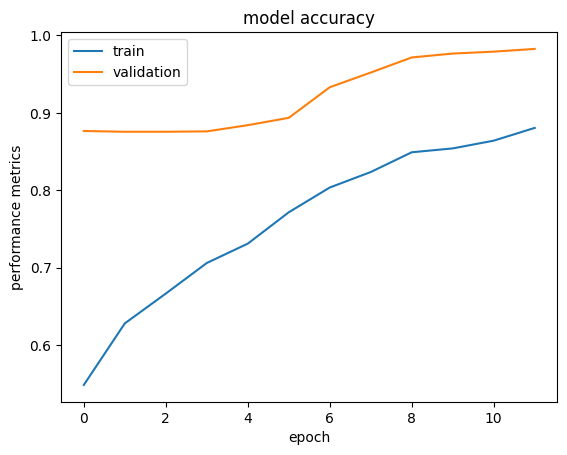

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


62/69 [=========================>....] - ETA: 0s - loss: 0.8202 - binary_accuracy: 0.5242 - recall_m: 0.6749 - precision_m: 0.1629 - f1_m: 0.2550

69/69 [==============================] - 4s 13ms/step - loss: 0.8081 - binary_accuracy: 0.5232 - recall_m: 0.6801 - precision_m: 0.1621 - f1_m: 0.2548 - val_loss: 0.7476 - val_binary_accuracy: 0.1950 - val_recall_m: 0.9855 - val_precision_m: 0.1293 - val_f1_m: 0.2241
Epoch 2/12
60/69 [=========================>....] - ETA: 0s - loss: 0.6242 - binary_accuracy: 0.5891 - recall_m: 0.8177 - precision_m: 0.1973 - f1_m: 0.3095

69/69 [==============================] - 0s 6ms/step - loss: 0.6212 - binary_accuracy: 0.5923 - recall_m: 0.8241 - precision_m: 0.2020 - f1_m: 0.3161 - val_loss: 0.7660 - val_binary_accuracy: 0.2091 - val_recall_m: 0.9855 - val_precision_m: 0.1317 - val_f1_m: 0.2276
Epoch 3/12
59/69 [========================>.....] - ETA: 0s - loss: 0.5249 - binary_accuracy: 0.6298 - recall_m: 0.8582 - precision_m: 0.2233 - f1_m: 0.3429

69/69 [==============================] - 0s 7ms/step - loss: 0.5286 - binary_accuracy: 0.6359 - recall_m: 0.8524 - precision_m: 0.2311 - f1_m: 0.3524 - val_loss: 0.6855 - val_binary_accuracy: 0.5164 - val_recall_m: 0.9837 - val_precision_m: 0.1974 - val_f1_m: 0.3205
Epoch 4/12
61/69 [=========================>....] - ETA: 0s - loss: 0.4681 - binary_accuracy: 0.6983 - recall_m: 0.9390 - precision_m: 0.2797 - f1_m: 0.4166

69/69 [==============================] - 1s 8ms/step - loss: 0.4656 - binary_accuracy: 0.6991 - recall_m: 0.9364 - precision_m: 0.2751 - f1_m: 0.4111 - val_loss: 0.6057 - val_binary_accuracy: 0.7477 - val_recall_m: 0.9638 - val_precision_m: 0.3140 - val_f1_m: 0.4608
Epoch 5/12
62/69 [=========================>....] - ETA: 0s - loss: 0.4224 - binary_accuracy: 0.7369 - recall_m: 0.8945 - precision_m: 0.2887 - f1_m: 0.4189

69/69 [==============================] - 1s 8ms/step - loss: 0.4318 - binary_accuracy: 0.7377 - recall_m: 0.8908 - precision_m: 0.2979 - f1_m: 0.4274 - val_loss: 0.5267 - val_binary_accuracy: 0.8464 - val_recall_m: 0.9099 - val_precision_m: 0.4272 - val_f1_m: 0.5650
Epoch 6/12
61/69 [=========================>....] - ETA: 0s - loss: 0.3976 - binary_accuracy: 0.7577 - recall_m: 0.9256 - precision_m: 0.3329 - f1_m: 0.4743

69/69 [==============================] - 0s 7ms/step - loss: 0.3934 - binary_accuracy: 0.7550 - recall_m: 0.9342 - precision_m: 0.3250 - f1_m: 0.4654 - val_loss: 0.4441 - val_binary_accuracy: 0.8950 - val_recall_m: 0.9118 - val_precision_m: 0.5318 - val_f1_m: 0.6505
Epoch 7/12
66/69 [===========================>..] - ETA: 0s - loss: 0.3896 - binary_accuracy: 0.7855 - recall_m: 0.8828 - precision_m: 0.3510 - f1_m: 0.4781

69/69 [==============================] - 0s 7ms/step - loss: 0.3884 - binary_accuracy: 0.7886 - recall_m: 0.8843 - precision_m: 0.3575 - f1_m: 0.4853 - val_loss: 0.3894 - val_binary_accuracy: 0.8932 - val_recall_m: 0.9453 - val_precision_m: 0.5355 - val_f1_m: 0.6604
Epoch 8/12
59/69 [========================>.....] - ETA: 0s - loss: 0.3305 - binary_accuracy: 0.8204 - recall_m: 0.8980 - precision_m: 0.3992 - f1_m: 0.5257

69/69 [==============================] - 1s 7ms/step - loss: 0.3380 - binary_accuracy: 0.8182 - recall_m: 0.9085 - precision_m: 0.3973 - f1_m: 0.5263 - val_loss: 0.3390 - val_binary_accuracy: 0.9005 - val_recall_m: 0.9448 - val_precision_m: 0.5594 - val_f1_m: 0.6807
Epoch 9/12
58/69 [========================>.....] - ETA: 0s - loss: 0.3362 - binary_accuracy: 0.8287 - recall_m: 0.8771 - precision_m: 0.4150 - f1_m: 0.5407

69/69 [==============================] - 0s 7ms/step - loss: 0.3322 - binary_accuracy: 0.8295 - recall_m: 0.8909 - precision_m: 0.4137 - f1_m: 0.5433 - val_loss: 0.2606 - val_binary_accuracy: 0.9314 - val_recall_m: 0.9471 - val_precision_m: 0.6493 - val_f1_m: 0.7497
Epoch 10/12
69/69 [==============================] - ETA: 0s - loss: 0.2902 - binary_accuracy: 0.8550 - recall_m: 0.9512 - precision_m: 0.4562 - f1_m: 0.5932

69/69 [==============================] - 1s 8ms/step - loss: 0.2902 - binary_accuracy: 0.8550 - recall_m: 0.9512 - precision_m: 0.4562 - f1_m: 0.5932 - val_loss: 0.2610 - val_binary_accuracy: 0.9173 - val_recall_m: 0.9592 - val_precision_m: 0.6059 - val_f1_m: 0.7193
Epoch 11/12
65/69 [===========================>..] - ETA: 0s - loss: 0.2589 - binary_accuracy: 0.8673 - recall_m: 0.9392 - precision_m: 0.4850 - f1_m: 0.6151

69/69 [==============================] - 1s 8ms/step - loss: 0.2581 - binary_accuracy: 0.8677 - recall_m: 0.9427 - precision_m: 0.4834 - f1_m: 0.6153 - val_loss: 0.2262 - val_binary_accuracy: 0.9291 - val_recall_m: 0.9621 - val_precision_m: 0.6425 - val_f1_m: 0.7506
Epoch 12/12
64/69 [==========================>...] - ETA: 0s - loss: 0.2537 - binary_accuracy: 0.8857 - recall_m: 0.9432 - precision_m: 0.5104 - f1_m: 0.6321

69/69 [==============================] - 0s 4ms/step - loss: 0.1782 - binary_accuracy: 0.9473 - recall_m: 0.9575 - precision_m: 0.7009 - f1_m: 0.7940
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
69/69 [==============================] - 0s 4ms/step - loss: 0.1782 - binary_accuracy: 0.9473 - recall_m: 0.9575 - precision_m: 0.7009 - f1_m: 0.7940
Test Accuracy
69/69 [==============================] - 0s 5ms/step - loss: 0.1782 - binary_accuracy: 0.9473 - recall_m: 0.9575 - precision_m: 0.7009 - f1_m: 0.7940


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-03-04 (10/12)


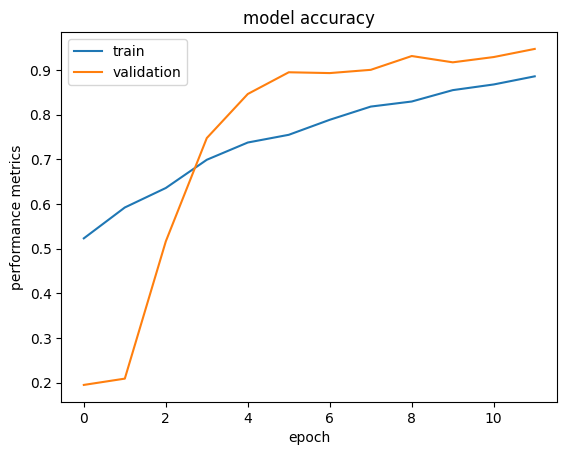

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/75 [===========================>..] - ETA: 0s - loss: 0.7582 - binary_accuracy: 0.5827 - recall_m: 0.5628 - precision_m: 0.1679 - f1_m: 0.2493

75/75 [==============================] - 3s 12ms/step - loss: 0.7475 - binary_accuracy: 0.5833 - recall_m: 0.5761 - precision_m: 0.1669 - f1_m: 0.2493 - val_loss: 0.6266 - val_binary_accuracy: 0.8883 - val_recall_m: 0.3782 - val_precision_m: 0.5112 - val_f1_m: 0.4058
Epoch 2/12
74/75 [============================>.] - ETA: 0s - loss: 0.5847 - binary_accuracy: 0.6807 - recall_m: 0.8047 - precision_m: 0.2557 - f1_m: 0.3682

75/75 [==============================] - 1s 7ms/step - loss: 0.5825 - binary_accuracy: 0.6796 - recall_m: 0.8073 - precision_m: 0.2532 - f1_m: 0.3650 - val_loss: 0.5459 - val_binary_accuracy: 0.8963 - val_recall_m: 0.2183 - val_precision_m: 0.5089 - val_f1_m: 0.2853
Epoch 3/12
67/75 [=========================>....] - ETA: 0s - loss: 0.5132 - binary_accuracy: 0.7076 - recall_m: 0.7875 - precision_m: 0.2797 - f1_m: 0.3922

75/75 [==============================] - 0s 6ms/step - loss: 0.5191 - binary_accuracy: 0.7054 - recall_m: 0.7847 - precision_m: 0.2795 - f1_m: 0.3929 - val_loss: 0.4888 - val_binary_accuracy: 0.8992 - val_recall_m: 0.2337 - val_precision_m: 0.5107 - val_f1_m: 0.3012
Epoch 4/12
63/75 [========================>.....] - ETA: 0s - loss: 0.4941 - binary_accuracy: 0.7401 - recall_m: 0.8030 - precision_m: 0.3072 - f1_m: 0.4275

75/75 [==============================] - 0s 6ms/step - loss: 0.4906 - binary_accuracy: 0.7437 - recall_m: 0.8085 - precision_m: 0.3106 - f1_m: 0.4312 - val_loss: 0.4338 - val_binary_accuracy: 0.9058 - val_recall_m: 0.3072 - val_precision_m: 0.6088 - val_f1_m: 0.3843
Epoch 5/12
66/75 [=========================>....] - ETA: 0s - loss: 0.4415 - binary_accuracy: 0.7685 - recall_m: 0.8355 - precision_m: 0.3410 - f1_m: 0.4700

75/75 [==============================] - 0s 6ms/step - loss: 0.4483 - binary_accuracy: 0.7646 - recall_m: 0.8379 - precision_m: 0.3350 - f1_m: 0.4634 - val_loss: 0.3881 - val_binary_accuracy: 0.9304 - val_recall_m: 0.5974 - val_precision_m: 0.8077 - val_f1_m: 0.6464
Epoch 6/12
63/75 [========================>.....] - ETA: 0s - loss: 0.4303 - binary_accuracy: 0.7897 - recall_m: 0.8762 - precision_m: 0.3622 - f1_m: 0.4896

75/75 [==============================] - 0s 6ms/step - loss: 0.4252 - binary_accuracy: 0.7950 - recall_m: 0.8800 - precision_m: 0.3727 - f1_m: 0.5016 - val_loss: 0.3455 - val_binary_accuracy: 0.9446 - val_recall_m: 0.7296 - val_precision_m: 0.8020 - val_f1_m: 0.7451
Epoch 7/12
65/75 [=========================>....] - ETA: 0s - loss: 0.3803 - binary_accuracy: 0.8178 - recall_m: 0.9134 - precision_m: 0.3971 - f1_m: 0.5319

75/75 [==============================] - 1s 7ms/step - loss: 0.3713 - binary_accuracy: 0.8188 - recall_m: 0.9171 - precision_m: 0.3992 - f1_m: 0.5362 - val_loss: 0.2858 - val_binary_accuracy: 0.9575 - val_recall_m: 0.8297 - val_precision_m: 0.8082 - val_f1_m: 0.7980
Epoch 8/12
72/75 [===========================>..] - ETA: 0s - loss: 0.3519 - binary_accuracy: 0.8433 - recall_m: 0.8979 - precision_m: 0.4428 - f1_m: 0.5627

75/75 [==============================] - 1s 8ms/step - loss: 0.3496 - binary_accuracy: 0.8433 - recall_m: 0.9020 - precision_m: 0.4427 - f1_m: 0.5642 - val_loss: 0.2649 - val_binary_accuracy: 0.9463 - val_recall_m: 0.9339 - val_precision_m: 0.7166 - val_f1_m: 0.7913
Epoch 9/12
73/75 [============================>.] - ETA: 0s - loss: 0.3418 - binary_accuracy: 0.8523 - recall_m: 0.9029 - precision_m: 0.4588 - f1_m: 0.5786

75/75 [==============================] - 0s 6ms/step - loss: 0.3408 - binary_accuracy: 0.8525 - recall_m: 0.9055 - precision_m: 0.4595 - f1_m: 0.5782 - val_loss: 0.2392 - val_binary_accuracy: 0.9392 - val_recall_m: 0.9561 - val_precision_m: 0.6878 - val_f1_m: 0.7791
Epoch 10/12
63/75 [========================>.....] - ETA: 0s - loss: 0.2841 - binary_accuracy: 0.8750 - recall_m: 0.9145 - precision_m: 0.5017 - f1_m: 0.6161

75/75 [==============================] - 0s 6ms/step - loss: 0.2830 - binary_accuracy: 0.8771 - recall_m: 0.9160 - precision_m: 0.5065 - f1_m: 0.6238 - val_loss: 0.1990 - val_binary_accuracy: 0.9538 - val_recall_m: 0.9787 - val_precision_m: 0.7310 - val_f1_m: 0.8195
Epoch 11/12
72/75 [===========================>..] - ETA: 0s - loss: 0.2507 - binary_accuracy: 0.8971 - recall_m: 0.9480 - precision_m: 0.5517 - f1_m: 0.6733

75/75 [==============================] - 1s 12ms/step - loss: 0.2508 - binary_accuracy: 0.8988 - recall_m: 0.9501 - precision_m: 0.5559 - f1_m: 0.6777 - val_loss: 0.1643 - val_binary_accuracy: 0.9658 - val_recall_m: 0.9892 - val_precision_m: 0.7851 - val_f1_m: 0.8558
Epoch 12/12
65/75 [=========================>....] - ETA: 0s - loss: 0.2351 - binary_accuracy: 0.9082 - recall_m: 0.9470 - precision_m: 0.5941 - f1_m: 0.6986

75/75 [==============================] - 0s 4ms/step - loss: 0.1684 - binary_accuracy: 0.9596 - recall_m: 0.9967 - precision_m: 0.7472 - f1_m: 0.8369
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
75/75 [==============================] - 0s 4ms/step - loss: 0.1684 - binary_accuracy: 0.9596 - recall_m: 0.9967 - precision_m: 0.7472 - f1_m: 0.8369
Test Accuracy
75/75 [==============================] - 0s 5ms/step - loss: 0.1684 - binary_accuracy: 0.9596 - recall_m: 0.9967 - precision_m: 0.7472 - f1_m: 0.8369


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-03-05 (11/12)


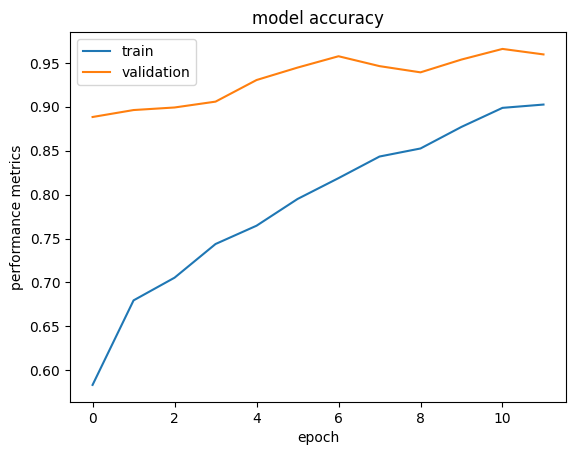

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/82 [========================>.....] - ETA: 0s - loss: 0.8339 - binary_accuracy: 0.5643 - recall_m: 0.5009 - precision_m: 0.1414 - f1_m: 0.2096

82/82 [==============================] - 3s 10ms/step - loss: 0.8133 - binary_accuracy: 0.5719 - recall_m: 0.5238 - precision_m: 0.1511 - f1_m: 0.2229 - val_loss: 0.5126 - val_binary_accuracy: 0.8750 - val_recall_m: 0.0054 - val_precision_m: 0.0244 - val_f1_m: 0.0085
Epoch 2/12
73/82 [=========================>....] - ETA: 0s - loss: 0.5930 - binary_accuracy: 0.6588 - recall_m: 0.7494 - precision_m: 0.2351 - f1_m: 0.3421

82/82 [==============================] - 1s 8ms/step - loss: 0.5958 - binary_accuracy: 0.6631 - recall_m: 0.7520 - precision_m: 0.2427 - f1_m: 0.3502 - val_loss: 0.4270 - val_binary_accuracy: 0.8742 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/12
76/82 [==========================>...] - ETA: 0s - loss: 0.5431 - binary_accuracy: 0.7035 - recall_m: 0.8101 - precision_m: 0.2764 - f1_m: 0.3923

82/82 [==============================] - 1s 10ms/step - loss: 0.5441 - binary_accuracy: 0.7046 - recall_m: 0.8093 - precision_m: 0.2782 - f1_m: 0.3929 - val_loss: 0.3857 - val_binary_accuracy: 0.8792 - val_recall_m: 0.0360 - val_precision_m: 0.1423 - val_f1_m: 0.0555
Epoch 4/12
77/82 [===========================>..] - ETA: 0s - loss: 0.4750 - binary_accuracy: 0.7585 - recall_m: 0.8750 - precision_m: 0.3311 - f1_m: 0.4589

82/82 [==============================] - 1s 10ms/step - loss: 0.4751 - binary_accuracy: 0.7558 - recall_m: 0.8608 - precision_m: 0.3254 - f1_m: 0.4502 - val_loss: 0.3511 - val_binary_accuracy: 0.8927 - val_recall_m: 0.1607 - val_precision_m: 0.4136 - val_f1_m: 0.2199
Epoch 5/12
75/82 [==========================>...] - ETA: 0s - loss: 0.4499 - binary_accuracy: 0.7796 - recall_m: 0.9053 - precision_m: 0.3524 - f1_m: 0.4887

82/82 [==============================] - 1s 10ms/step - loss: 0.4537 - binary_accuracy: 0.7815 - recall_m: 0.9006 - precision_m: 0.3612 - f1_m: 0.4958 - val_loss: 0.3127 - val_binary_accuracy: 0.9065 - val_recall_m: 0.3220 - val_precision_m: 0.6392 - val_f1_m: 0.4067
Epoch 6/12
80/82 [============================>.] - ETA: 0s - loss: 0.4370 - binary_accuracy: 0.7848 - recall_m: 0.8437 - precision_m: 0.3613 - f1_m: 0.4706

82/82 [==============================] - 1s 11ms/step - loss: 0.4379 - binary_accuracy: 0.7854 - recall_m: 0.8435 - precision_m: 0.3660 - f1_m: 0.4748 - val_loss: 0.2857 - val_binary_accuracy: 0.9338 - val_recall_m: 0.5911 - val_precision_m: 0.7754 - val_f1_m: 0.6421
Epoch 7/12
81/82 [============================>.] - ETA: 0s - loss: 0.3878 - binary_accuracy: 0.8194 - recall_m: 0.8449 - precision_m: 0.4144 - f1_m: 0.5353

82/82 [==============================] - 1s 10ms/step - loss: 0.3871 - binary_accuracy: 0.8196 - recall_m: 0.8468 - precision_m: 0.4155 - f1_m: 0.5369 - val_loss: 0.2583 - val_binary_accuracy: 0.9465 - val_recall_m: 0.7847 - val_precision_m: 0.7457 - val_f1_m: 0.7426
Epoch 8/12
77/82 [===========================>..] - ETA: 0s - loss: 0.3673 - binary_accuracy: 0.8356 - recall_m: 0.8841 - precision_m: 0.4374 - f1_m: 0.5587

82/82 [==============================] - 1s 11ms/step - loss: 0.3628 - binary_accuracy: 0.8362 - recall_m: 0.8851 - precision_m: 0.4415 - f1_m: 0.5580 - val_loss: 0.2465 - val_binary_accuracy: 0.9438 - val_recall_m: 0.9117 - val_precision_m: 0.6906 - val_f1_m: 0.7698
Epoch 9/12
74/82 [==========================>...] - ETA: 0s - loss: 0.3439 - binary_accuracy: 0.8535 - recall_m: 0.8917 - precision_m: 0.4826 - f1_m: 0.6047

82/82 [==============================] - 1s 9ms/step - loss: 0.3399 - binary_accuracy: 0.8492 - recall_m: 0.8749 - precision_m: 0.4609 - f1_m: 0.5805 - val_loss: 0.2214 - val_binary_accuracy: 0.9554 - val_recall_m: 0.9361 - val_precision_m: 0.7218 - val_f1_m: 0.8018
Epoch 10/12
82/82 [==============================] - ETA: 0s - loss: 0.3148 - binary_accuracy: 0.8592 - recall_m: 0.9248 - precision_m: 0.4885 - f1_m: 0.6086

82/82 [==============================] - 1s 12ms/step - loss: 0.3148 - binary_accuracy: 0.8592 - recall_m: 0.9248 - precision_m: 0.4885 - f1_m: 0.6086 - val_loss: 0.1939 - val_binary_accuracy: 0.9604 - val_recall_m: 0.9427 - val_precision_m: 0.7538 - val_f1_m: 0.8210
Epoch 11/12
76/82 [==========================>...] - ETA: 0s - loss: 0.2688 - binary_accuracy: 0.8873 - recall_m: 0.9357 - precision_m: 0.5337 - f1_m: 0.6503

82/82 [==============================] - 1s 8ms/step - loss: 0.2693 - binary_accuracy: 0.8865 - recall_m: 0.9363 - precision_m: 0.5319 - f1_m: 0.6501 - val_loss: 0.1864 - val_binary_accuracy: 0.9546 - val_recall_m: 0.9543 - val_precision_m: 0.7281 - val_f1_m: 0.8115
Epoch 12/12
75/82 [==========================>...] - ETA: 0s - loss: 0.2451 - binary_accuracy: 0.9013 - recall_m: 0.9452 - precision_m: 0.5843 - f1_m: 0.6961

82/82 [==============================] - 0s 3ms/step - loss: 0.1581 - binary_accuracy: 0.9604 - recall_m: 0.9573 - precision_m: 0.7465 - f1_m: 0.8256
dict_keys(['loss', 'binary_accuracy', 'recall_m', 'precision_m', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_recall_m', 'val_precision_m', 'val_f1_m'])
Train Accuracy
82/82 [==============================] - 0s 2ms/step - loss: 0.1581 - binary_accuracy: 0.9604 - recall_m: 0.9573 - precision_m: 0.7465 - f1_m: 0.8256
Test Accuracy
82/82 [==============================] - 0s 4ms/step - loss: 0.1581 - binary_accuracy: 0.9604 - recall_m: 0.9573 - precision_m: 0.7465 - f1_m: 0.8256
Current date: 2022-03-06 (12/12)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


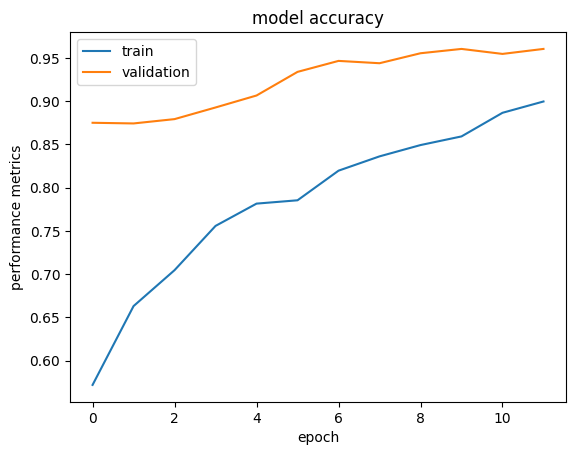

In [31]:

# Dict with all the labelled elements, every iteration it is filled with #{BUDGET} more labelled elements
labelled_elements = {}

x, y = [], []

for date in pd.date_range(min_date, max_date - pd.Timedelta(days=1)):
  curr = df[df.ts.dt.date == date.date()]
  next = df[df.ts.dt.date == (date + pd.Timedelta(days=1)).date()]


  # ACTIVE LEARNING PART: selecting which elements to use for training
  if AL_EFFICIENCY == "optimal":
    x.append(curr["embedding"])
    y.append(curr[LABEL])
  elif AL_EFFICIENCY == "normal":
    labelled_elements = al_methods[AL_METHOD](curr, labelled_elements, BUDGET, LABEL)
    x, y = list(labelled_elements.keys()), list(labelled_elements.values())
  elif AL_EFFICIENCY == "forgetful":
    labelled_elements = al_methods[AL_METHOD](curr, {}, BUDGET, LABEL)
    x, y = list(labelled_elements.keys()), list(labelled_elements.values())
  else:
      x, y = [], []



  # Getting correct sets
  x_train, y_train, x_test, y_test, x_val, y_val = get_network_sets(x, y, next)

  # Creating model
  model, callback = create_model()

  # Calculating weights for better cnn performance
  class_weights = compute_class_weight(class_weight='balanced', classes=list(set(y)), y=y)
  class_weights = {class_index: weight for class_index, weight in enumerate(class_weights)}

  # Training model
  history = model.fit(x_train, y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=([x_val, y_val]),
                      callbacks=callback,
                      class_weight=class_weights)

  # Evaluating Model
  model.evaluate(x_test, y_test, verbose=1)

  print('Train Accuracy')
  model.evaluate(x_train, y_train)
  print('Test Accuracy')
  model.evaluate(x_test, y_test)
  history.history['binary_accuracy']

  model.save('prova.h5')



  print(f"Current date: {date.date()} ({(pd.to_datetime(date) - pd.to_datetime(min_date)).days}/{((max_date - min_date).days - 1)})")
  plot_results(history)


### Example

In [32]:

examples = {"Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll" : 1.0,
            "Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies" : 0.0,
            "Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1" : 0.0,
            "Inter Milano has defeated Dynamo Kiev once again! ⚽️🔵⚫️ #InterMilan #ChampionsLeague" : 0.0,
            "Thoughts with Palestine during this difficult time, may the souls of the departed find tranquility in the afterlife 🕊️💔 #EternalPeace" : 1.0,
}

for text_example, label in examples.items():

  encoded_text = [embed_text(text_example)]
  encoded_text = np.array(encoded_text)

  output = model.predict(encoded_text)[0][0]

  print(f"Text: {text_example}\nDesired output: {decision(label)}\nActual output: {decision(output)} ({output})")


1/1 [==============================] - 0s 237ms/step
Text: Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll
Desired output: True
Actual output: True (0.756019651889801)
1/1 [==============================] - 0s 30ms/step
Text: Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies
Desired output: False
Actual output: False (0.02409740351140499)
1/1 [==============================] - 0s 36ms/step
Text: Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1
Desired output: False
Actual output: True (0.9596958160400391)
1/1 [==============================] - 0s 32ms/step
Text: Inter Milano has defeated Dynamo Kiev once again! ⚽️🔵⚫️ #InterMilan #ChampionsLeague
Desired output: False
Actual output: False (0.1839672178030014)
1/1 [==============================] - 0s 29ms/step
Text: Thoughts with Palestine during th

In [45]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-6_H-512_A-8' # @param {type:"string"}

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
